In [1]:
from web3 import Web3
import os
from dotenv import load_dotenv
import pandas as pd
import prophet
import numpy as np
import datetime as dt
from datetime import timedelta
from prophet import Prophet
from eth_account import Account
# from web3.middleware import geth_poa_middleware
from eth_abi import decode
from eth_utils import decode_hex, to_text

import requests
import random
import json

from dune_client.client import DuneClient

import plotly.graph_objs as go

from diskcache import Cache

In [2]:
load_dotenv()

ETHERSCAN_KEY = os.getenv("ETHERSCAN_KEY")
COINGECKO_API_KEY = os.getenv("COINGECKO_API_KEY")
DUNE_API_KEY = os.getenv('DUNE_API_KEY')
FLIPSIDE_API_KEY=os.getenv('FLIPSIDE_API_KEY')
dune = DuneClient(DUNE_API_KEY)

GAS_ACCOUNTANT = os.getenv("GAS_ACCOUNTANT")
GAS_RESERVE = os.getenv('GAS_RESERVE')
ACCOUNT_ADDRESS = os.getenv("ACCOUNT_ADDRESS")
PRIVATE_KEY = os.getenv("PRIVATE_KEY")
YIELD_FARM_ADDRESS = os.getenv("YIELD_FARM_ADDRESS")
STAKING_CONTRACT = os.getenv("STAKING_CONTRACT")
SEPOLIA_GATEWAY = os.getenv("SEPOLIA_GATEWAY")

BOT_1_ADDRESS=os.getenv("BOT_1_ADDRESS")
BOT_2_ADDRESS=os.getenv("BOT_2_ADDRESS")

In [3]:
os.chdir('..')

api = True

In [4]:
def get_price_timeseries(token='ethereum',days='90'):

    url = f"https://api.coingecko.com/api/v3/coins/{token}/market_chart?vs_currency=usd&days={days}"

    headers = {
        "accept": "application/json",
        "x-cg-demo-api-key": COINGECKO_API_KEY
    }

    response = requests.get(url, headers=headers)
    response_text = response.text
    data = json.loads(response_text)
    df_prices = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
    df_prices["timestamp"] = pd.to_datetime(df_prices["timestamp"], unit='ms')  # Convert to datetime
    df_prices.set_index('timestamp', inplace=True)
    return df_prices

In [5]:
eth_df = get_price_timeseries()

In [6]:
eth_df

,price
timestamp,
2024-12-24 03:04:03.844,3370.984823
2024-12-24 04:01:15.307,3390.475852
2024-12-24 05:04:00.605,3409.106971
2024-12-24 06:11:24.217,3413.365927
2024-12-24 07:04:02.827,3389.150603
...,...
2025-03-23 23:05:28.627,1987.331383
2025-03-24 00:04:50.749,2007.214551
2025-03-24 01:06:54.906,1993.867203


In [4]:
base_cache_dir = os.getcwd()
cache = Cache(os.path.join(base_cache_dir, 'cache')) 

In [5]:
gas_reserve_data = cache.get(f'gas_reserve_spent', pd.DataFrame())
gas_reserve_data

,hash,gas used,dt
0,0x577b9e019f157cc00b97457b643f2ff81c6833eafadb...,111159,NaT
1,5a154dbb06508f37638d186bef00f0f52a45b26cb06be2...,59016,2025-03-22 13:27:22.533021
2,d4aafce36c0974f876d415e2fc9b7cbc8ec73c595f4d11...,75904,2025-03-22 13:48:16.229419
3,59e53c2ad06dc626507eada28e0b3f717770e6eda508c7...,75904,2025-03-22 13:48:37.040989
4,19e8ecac1400feced9aba5592bc671276378035a15f953...,75904,2025-03-22 13:49:02.293270
5,4107fbd3c289a30f6d49bba45cf14bf83ba8cdc760a2f0...,200000,2025-03-22 13:55:21.412557
6,d8bccd6064b3c4a5968bd5f85a22d466c435b738a62316...,75904,2025-03-22 14:26:54.642477


In [6]:
abi_path = r'gas_accountant_contracts\contracts\artifacts'
abi_paths = []  # Assuming GAS_ACCOUNTANT_ABI_PATH is predefined

for file in os.listdir(abi_path):
    if file.endswith('.json') and "metadata" not in file:  # Exclude metadata files
        abi_paths.append(os.path.join(abi_path, file))  # Add full path

print(abi_paths)  # Debug: Check the final list

abis = {}

for path in abi_paths:
    filename = os.path.basename(path)  # Extract filename (e.g., "YieldVault.json")
    name = os.path.splitext(filename)[0]  # Remove .json extension (e.g., "YieldVault")

    with open(path, "r") as file:
        abis[name] = json.load(file)  # Use name as key

print(abis)  # Debug output

['gas_accountant_contracts\\contracts\\artifacts\\BatchTransfer.json', 'gas_accountant_contracts\\contracts\\artifacts\\GasReserve.json', 'gas_accountant_contracts\\contracts\\artifacts\\IGasReserve.json', 'gas_accountant_contracts\\contracts\\artifacts\\ILiquidStaking.json', 'gas_accountant_contracts\\contracts\\artifacts\\LiquidStaking.json', 'gas_accountant_contracts\\contracts\\artifacts\\StETHStrategy.json', 'gas_accountant_contracts\\contracts\\artifacts\\TestBTC.json', 'gas_accountant_contracts\\contracts\\artifacts\\TestETH.json', 'gas_accountant_contracts\\contracts\\artifacts\\YieldVault.json']
{'BatchTransfer': {'deploy': {'VM:-': {'linkReferences': {}, 'autoDeployLib': True}, 'main:1': {'linkReferences': {}, 'autoDeployLib': True}, 'ropsten:3': {'linkReferences': {}, 'autoDeployLib': True}, 'rinkeby:4': {'linkReferences': {}, 'autoDeployLib': True}, 'kovan:42': {'linkReferences': {}, 'autoDeployLib': True}, 'goerli:5': {'linkReferences': {}, 'autoDeployLib': True}, 'Custom'

In [7]:
abis.keys()

dict_keys(['BatchTransfer', 'GasReserve', 'IGasReserve', 'ILiquidStaking', 'LiquidStaking', 'StETHStrategy', 'TestBTC', 'TestETH', 'YieldVault'])

In [8]:
w3 = Web3(Web3.HTTPProvider(SEPOLIA_GATEWAY))

ACCOUNT = Account.from_key(PRIVATE_KEY)

w3.eth.default_account = ACCOUNT.address
# w3.middleware_onion.inject(geth_poa_middleware, layer=0)

In [9]:
def dune_api_results(query_num, save_csv=False, csv_path=None):
    results = dune.get_latest_result(query_num)
    df = pd.DataFrame(results.result.rows)

    if save_csv and csv_path:
        df.to_csv(csv_path, index=False)
    return df

In [10]:
def get_token_price(token='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'):
    url = f"https://api.coingecko.com/api/v3/simple/token_price/ethereum?contract_addresses={token}&vs_currencies=usd"

    headers = {
        "accept": "application/json",
        "x-cg-demo-api-key": COINGECKO_API_KEY
    }

    response = requests.get(url, headers=headers)

    

    eth_data = response.json()

    eth_df = pd.DataFrame(eth_data)
    eth_usd = eth_df[f'{token}'].values[0]

    print(eth_usd)

    return eth_usd

In [11]:
def process_transaction(tx):
    gas_price = float(tx.get("gasPrice", np.nan))  # Allow gasPrice to be NaN
    gas_used = int(tx["gasUsed"])
    
    return {
        "blockNumber": int(tx["blockNumber"]),
        "timestamp": dt.datetime.utcfromtimestamp(int(tx["timeStamp"])),
        "transaction_hash": tx["hash"],
        "from": tx["from"],
        "to": tx["to"] if tx.get("to") else "Contract Deployment",
        "gas": int(tx["gas"]),
        "gasPrice": gas_price,  # Leave NaN if missing
        "gasUsed": gas_used,
        "tx_fee": (gas_used * gas_price / 1e18) if not np.isnan(gas_price) else np.nan,  # Handle NaN in calculation
        "contractAddress": tx.get("contractAddress"),  # Default to None if contractAddress is missing
    }


In [12]:
def get_tx_and_log_with_pagination(contract_address, start_block, end_block, etherscan_api_key,module='account',action='txlist'):
    """
    Fetch logs for a contract address with pagination support from the Etherscan API.

    Parameters:
        contract_address (str): The contract address to fetch logs for.
        start_block (int): The starting block number.
        end_block (int): The ending block number or "latest".
        etherscan_api_key (str): Your Etherscan API key.
        topic_filters (dict, optional): A dictionary of topic filters, e.g.,
            {
                "topic0": "0xe085b50dde9f45e2f6290b8f6eadc05e9f66d77b30d750cb3930c5e3430b9c1e",
                "topic1": "0x0000000000000000000000002102240d1a36a9dc9f3a4d07ee9251cb723aca89",
                "topic2": None,
                "topic3": None,
                "topic0_1_opr": "and"
            }

    Returns:
        list: A list of logs fetched from the API.
    """
    if module == 'account':
        data_pulled = 'tx'
    else:
        data_pulled = 'log'

    base_url = "https://api-sepolia.etherscan.io/api"
    logs = []  # To store all logs
    page = 1
    offset = 1000  # Max records per page

    while True:
        # Construct the base URL
        url = (
            f"{base_url}?module={module}"
            f"&action={action}"
            f"&address={contract_address}"
            f"&fromBlock={start_block}"
            f"&toBlock={end_block}"
            f"&page={page}"
            f"&offset={offset}"
            f"&apikey={etherscan_api_key}"
        )

        try:
            # Make the API request
            response = requests.get(url)
            response.raise_for_status()

            data = response.json()
            if data["status"] != "1":  # Etherscan returns "1" for success
                print(f"No more {data_pulled}s or error: {data.get('message', 'Unknown error')}")
                break

            logs.extend(data["result"])  # Append the logs to the list
            print(f"Fetched {len(data['result'])} {data_pulled}s from page {page}.")

            # Stop if fewer than `offset` logs are returned
            if len(data["result"]) < offset:
                print(f"All {data_pulled}s fetched.")
                break

            page += 1  # Move to the next page

        except requests.RequestException as e:
            print(f"Error while fetching {data_pulled}s: {e}")
            break

    return logs

In [13]:
def parse_gas_log(log):
    """
    Parse a gas request log entry.

    Parameters:
        log (dict): A raw log entry from Etherscan.

    Returns:
        dict: Parsed log data.
    """
    # Extract transaction hash
    tx_hash = log["transactionHash"]

    # Extract requester's address from topic[1]
    requester = "0x" + log["topics"][1][-40:]

    # Decode data fields
    data = log["data"][2:]  # Remove "0x"
    timestamp = int(data[0:64], 16)  # Convert hex to int
    amount = int(data[64:128], 16) / 1e18  # Convert to ETH

    # Convert timestamp to human-readable format
    timestamp_human = dt.datetime.utcfromtimestamp(timestamp)

    return {
        "timestamp": timestamp_human,
        "transaction_hash": tx_hash,
        "requester": requester,
        "gas_amount_eth": amount,
    }


In [14]:
def token_prices(token_addresses, network, start_date):
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    """
    Generate a SQL query to get historical price data for given token addresses from a specific start date.

    Parameters:
    - token_addresses (list): List of token addresses.
    - start_date (str): Start date in 'YYYY-MM-DD' format.

    Returns:
    - str: The SQL query string.
    """
    # Format the addresses into the SQL VALUES clause
    addresses_clause = ", ".join(f"(LOWER('{address}'))" for address in token_addresses)

    beginning = f"'{start_date.strftime('%Y-%m-%d %H:%M:%S')}'"
    print('Beginning:', beginning)
    
    prices_query = f"""
    WITH addresses AS (
        SELECT column1 AS token_address 
        FROM (VALUES
            {addresses_clause}
        ) AS tokens(column1)
    )

    SELECT 
        hour,
        symbol,
        price
    FROM 
        {network}.price.ez_prices_hourly
    WHERE 
        token_address IN (SELECT token_address FROM addresses)
        AND hour >= DATE_TRUNC('hour', TO_TIMESTAMP({beginning}, 'YYYY-MM-DD HH24:MI:SS'))
    ORDER BY 
        hour DESC, symbol
    """

    return prices_query

In [15]:
def flipside_api_results(query, api_key, attempts=10, delay=30):
    """
    Creates and retrieves results for a query using Flipside's JSON-RPC API with pagination.

    Parameters:
    - query: str, the SQL query to execute.
    - api_key: str, your Flipside API key.
    - attempts: int, number of attempts to poll for query completion.
    - delay: int, delay (in seconds) between polling attempts.

    Returns:
    - pd.DataFrame: DataFrame containing the query results.
    """
    import requests
    import time
    import pandas as pd

    # Step 1: Create the query
    url = "https://api-v2.flipsidecrypto.xyz/json-rpc"
    headers = {
        "Content-Type": "application/json",
        "x-api-key": api_key
    }
    payload = {
        "jsonrpc": "2.0",
        "method": "createQueryRun",
        "params": [
            {
                "resultTTLHours": 1,
                "maxAgeMinutes": 0,
                "sql": query,
                "tags": {"source": "python-script", "env": "production"},
                "dataSource": "snowflake-default",
                "dataProvider": "flipside"
            }
        ],
        "id": 1
    }

    response = requests.post(url, headers=headers, json=payload)
    response_data = response.json()

    if 'error' in response_data:
        raise Exception(f"Error creating query: {response_data['error']['message']}")

    query_run_id = response_data.get('result', {}).get('queryRun', {}).get('id')
    if not query_run_id:
        raise KeyError(f"Query creation failed. Response: {response_data}")

    # Step 2: Poll for query completion
    for attempt in range(attempts):
        status_payload = {
            "jsonrpc": "2.0",
            "method": "getQueryRunResults",
            "params": [
                {
                    "queryRunId": query_run_id,
                    "format": "json",
                    "page": {"number": 1, "size": 10000}
                }
            ],
            "id": 1
        }
        response = requests.post(url, headers=headers, json=status_payload)
        resp_json = response.json()

        if 'result' in resp_json and 'rows' in resp_json['result']:
            # Step 3: Handle pagination
            all_rows = []
            page_number = 1

            while True:
                status_payload["params"][0]["page"]["number"] = page_number
                response = requests.post(url, headers=headers, json=status_payload)
                resp_json = response.json()

                if 'result' in resp_json and 'rows' in resp_json['result']:
                    rows = resp_json['result']['rows']
                    if not rows:
                        break  # No more rows to fetch
                    all_rows.extend(rows)
                    page_number += 1
                else:
                    break

            # Convert the rows to a DataFrame
            return pd.DataFrame(all_rows)

        if 'error' in resp_json and 'not yet completed' in resp_json['error'].get('message', '').lower():
            time.sleep(delay)  # Wait before retrying
        else:
            raise Exception(f"Unexpected error while fetching query results: {resp_json}")

    raise TimeoutError(f"Query did not complete after {attempts} attempts.")

In [16]:
def to_time(df):
    time_cols = ['date','dt','hour','time','day','month','year','week','timestamp','date(utc)','block_timestamp']
    for col in df.columns:
        if col.lower() in time_cols and col.lower() != 'timestamp':
            df[col] = pd.to_datetime(df[col])
            df.set_index(col, inplace=True)
        elif col.lower() == 'timestamp':
            df[col] = pd.to_datetime(df[col], unit='ms')
            df.set_index(col, inplace=True)
    print(df.index)
    return df 

def clean_prices(prices_df):
    print('cleaning prices')
    # Pivot the dataframe
    breakpoint()
    prices_df = prices_df.drop_duplicates(subset=['hour', 'symbol'])
    prices_df_pivot = prices_df.pivot(
        index='hour',
        columns='symbol',
        values='price'
    )
    prices_df_pivot = prices_df_pivot.reset_index()

    # Rename the columns by combining 'symbol' with a suffix
    prices_df_pivot.columns = ['dt'] + [f'{col}_price' for col in prices_df_pivot.columns[1:]]
    
    print(f'cleaned prices: {prices_df_pivot}')
    return prices_df_pivot

In [17]:
def data_processing(df,dropna=True):
    df.columns=df.columns.str.lower()
    clean_df = clean_prices(df)
    clean_df = to_time(clean_df)
    if dropna == True:
        clean_df = clean_df.dropna(axis=1, how='any')

    if '__row_index' in clean_df.columns:
        clean_df.drop(columns=['__row_index'], inplace=True)

    return clean_df

In [18]:
def update_eth_price_data(new_data):
    historical_data = cache.get(f'ETH Prices', pd.DataFrame())
    historical_data = pd.concat([historical_data, new_data]).reset_index(drop=True)
    historical_data.drop_duplicates(subset='hour', keep='last', inplace=True)
    cache.set(f'ETH Prices', historical_data)

def update_balance_data(values):
    print(f'values: {values}')
    # values = pd.DataFrame([values])
    historical_port_values = cache.get(f'balance_data')
    historical_port_values = pd.concat([historical_port_values, values]).reset_index(drop=True)
    print(f'historical_port_values: {historical_port_values}')
    # breakpoint()
    historical_port_values.drop_duplicates(subset='hour', keep='first', inplace=True)
    cache.set(f'balance_data', historical_port_values)

def update_forecast_gas_data(values):
    # print(f'values at update price: {values}')

    # Ensure the 'hour' column exists by resetting index if necessary
    if isinstance(values.index, pd.DatetimeIndex):
        values = values.reset_index().rename(columns={'index': 'hour'})
    
    if 'hour' not in values.columns:
        raise ValueError("The provided DataFrame must have a 'hour' column.")

    oracle_prices = cache.get(f'forecast_price_data', pd.DataFrame())
    # breakpoint()

    # Concatenate the new values with the existing oracle_prices
    oracle_prices = pd.concat([oracle_prices, values]).drop_duplicates(subset='hour', keep='first').reset_index(drop=True)

    # breakpoint()
    
    # Cache the updated oracle_prices
    cache.set(f'forecast_price_data', oracle_prices)

    print(f'Updated forecast_price_data:\n{oracle_prices}')

def update_historical_gas_data(values):
    # print(f'values at update price: {values}')

    # Ensure the 'hour' column exists by resetting index if necessary
    if isinstance(values.index, pd.DatetimeIndex):
        values = values.reset_index().rename(columns={'index': 'hour'})
    
    if 'hour' not in values.columns:
        raise ValueError("The provided DataFrame must have a 'hour' column.")

    oracle_prices = cache.get(f'historical_gas_data', pd.DataFrame())
    # breakpoint()

    # Concatenate the new values with the existing oracle_prices
    oracle_prices = pd.concat([oracle_prices, values]).drop_duplicates(subset='hour', keep='first').reset_index(drop=True)

    # breakpoint()
    
    # Cache the updated oracle_prices
    cache.set(f'historical_gas_data', oracle_prices)

    print(f'Updated historical_gas_data:\n{oracle_prices}')

def update_contract_data(data):
    print(f'new data: {data}')
    model_actions = cache.get(f'contract_data', pd.DataFrame())
    print(f'model actions before update: {data}')
    model_actions = pd.concat([model_actions, data]).reset_index(drop=True)
    model_actions.drop_duplicates(subset='hour', keep='first', inplace=True)
    cache.set(f'contract_data', model_actions)

In [19]:
def get_eth_balances(api_key, addresses):
    """
    Fetch balances for multiple Ethereum addresses from Etherscan (Sepolia).
    
    :param api_key: Your Etherscan API key as a string.
    :param addresses: A list of Ethereum addresses.
    :return: JSON response with balances.
    """
    base_url = "https://api-sepolia.etherscan.io/api"
    
    # Convert list of addresses to comma-separated string
    addresses_str = ",".join(addresses)
    
    # Construct the API request URL
    params = {
        "module": "account",
        "action": "balancemulti",
        "address": addresses_str,
        "tag": "latest",
        "apikey": api_key
    }
    
    # Make the request
    response = requests.get(base_url, params=params)
    
    # Return the JSON response
    return response.json()

# Gas Price Forecasting

In [20]:
def get_sepolia_gas_history(api, term='long_term'):
    lt_sepolia_gas_data_path = 'data/sepolia_gas_metrics.csv'
    st_sepolia_gas_data_path = 'data/current_sepolia_gas_metrics.csv'

    if api:
        if term == 'long_term':
            query = 4622627  # 2 Years worth
            sepolia_gas_data = dune_api_results(query, True, lt_sepolia_gas_data_path)
            sepolia_gas_data.to_csv(lt_sepolia_gas_data_path, index=False)  # ✅ Moved inside block
        
        elif term == 'short_term':
            query = 4650506  # Runs daily at midnight for latest prices
            sepolia_gas_data = dune_api_results(query, True, st_sepolia_gas_data_path)
            sepolia_gas_data.to_csv(st_sepolia_gas_data_path, index=False)

        else:
            print('Pass "long_term" or "short_term" as parameters')
            return None

    else:
        if term == 'long_term':
            sepolia_gas_data = pd.read_csv(lt_sepolia_gas_data_path)
        elif term == 'short_term':
            sepolia_gas_data = pd.read_csv(st_sepolia_gas_data_path)
        else:
            print('Pass "long_term" or "short_term" as parameters')
            return None

    # Convert 'hour' column to datetime format
    sepolia_gas_data['hour'] = pd.to_datetime(sepolia_gas_data['hour'])

    return sepolia_gas_data

In [21]:
api = False

In [22]:
long_term_sepolia_gas = get_sepolia_gas_history(api,'long_term')

In [23]:
short_term_sepolia_gas = get_sepolia_gas_history(api,'short_term')

In [24]:
short_term_sepolia_gas

,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price
0,2025-03-22 19:00:00+00:00,100000000000,4.702929e+08,2681125,4.935564e+06,1.503049e+09
1,2025-03-22 18:00:00+00:00,208736455613,3.244647e+08,2655729,4.753002e+06,1.503047e+09
2,2025-03-22 17:00:00+00:00,253400925441,6.321782e+08,2821181,4.950885e+06,1.503269e+09
3,2025-03-22 16:00:00+00:00,650000000000,1.025809e+09,2780586,5.246529e+06,1.503359e+09
4,2025-03-22 15:00:00+00:00,2430000000000,1.130067e+09,2793677,5.529972e+06,1.503372e+09
5,2025-03-22 14:00:00+00:00,266319902997,9.946769e+08,2834688,5.253173e+06,1.503374e+09
6,2025-03-22 13:00:00+00:00,2620187318643,1.003423e+09,2784100,6.539168e+06,1.503942e+09
7,2025-03-22 12:00:00+00:00,833183482281,1.050332e+09,2752243,5.173167e+06,1.503305e+09
8,2025-03-22 11:00:00+00:00,366653134070,8.516019e+08,2672886,4.999306e+06,1.503224e+09
9,2025-03-22 10:00:00+00:00,252471813329,1.113845e+09,2832052,5.352948e+06,1.503339e+09


In [25]:
long_term_sepolia_gas

,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price
0,2025-03-22 19:00:00+00:00,100000000000,4.798578e+08,2681125,4.929396e+06,1.503053e+09
1,2025-03-22 18:00:00+00:00,208736455613,3.181253e+08,2655729,4.750067e+06,1.503050e+09
2,2025-03-22 17:00:00+00:00,253400925441,6.336744e+08,2821181,4.954034e+06,1.503271e+09
3,2025-03-22 16:00:00+00:00,650000000000,1.022745e+09,2780586,5.250384e+06,1.503357e+09
4,2025-03-22 15:00:00+00:00,2430000000000,1.123705e+09,2793677,5.522206e+06,1.503371e+09
...,...,...,...,...,...,...
17295,2023-04-02 04:00:00+00:00,428571428571,1.605303e+09,7,1.500000e+09,4.500000e+09
17296,2023-04-02 03:00:00+00:00,300000000000,2.210777e+09,7,1.500000e+09,4.500000e+09
17297,2023-04-02 02:00:00+00:00,500000000007,1.841365e+09,7,1.500000e+09,4.500000e+09
17298,2023-04-02 01:00:00+00:00,428571428571,1.613547e+09,7,1.500000e+09,4.500000e+09


In [26]:
def set_global_seed(env, seed=20):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


In [27]:
target = 'median_gas_price'
days = 30

target_df = long_term_sepolia_gas.set_index('hour')[[target]]

<Axes: xlabel='hour'>

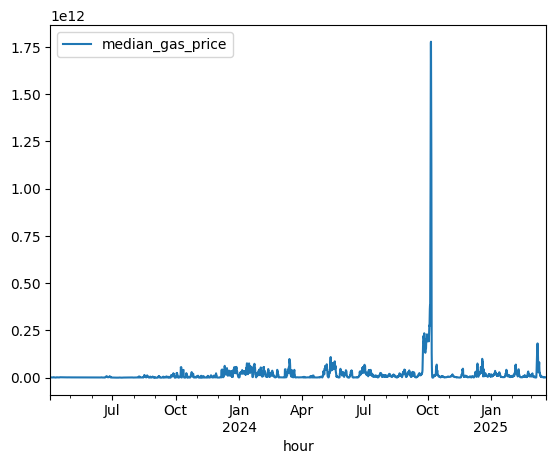

In [28]:
target_df.rolling(window=days).mean().plot()

In [29]:
target_df.reset_index(inplace=True)
target_df.rename(columns={"hour":"ds","median_gas_price":"y"},inplace=True)

In [30]:
target_df['ds'] = pd.to_datetime(target_df['ds'])
print(target_df.dtypes)


ds    datetime64[ns, UTC]
y                 float64
dtype: object


In [31]:
target_df['ds'] = target_df['ds'].dt.strftime('%Y-%m-%d %H:00:00')


In [32]:
target_df

,ds,y
0,2025-03-22 19:00:00,4.798578e+08
1,2025-03-22 18:00:00,3.181253e+08
2,2025-03-22 17:00:00,6.336744e+08
3,2025-03-22 16:00:00,1.022745e+09
4,2025-03-22 15:00:00,1.123705e+09
...,...,...
17295,2023-04-02 04:00:00,1.605303e+09
17296,2023-04-02 03:00:00,2.210777e+09
17297,2023-04-02 02:00:00,1.841365e+09
17298,2023-04-02 01:00:00,1.613547e+09


In [33]:
target_df.describe()

,y
count,1.730000e+04
mean,1.881784e+10
std,9.452444e+10
min,1.520785e+01
25%,1.220719e+09
50%,1.938096e+09
75%,9.656103e+09
max,4.328198e+12


In [34]:
target_df['ds'] = pd.to_datetime(target_df['ds'])


In [35]:
target_df

,ds,y
0,2025-03-22 19:00:00,4.798578e+08
1,2025-03-22 18:00:00,3.181253e+08
2,2025-03-22 17:00:00,6.336744e+08
3,2025-03-22 16:00:00,1.022745e+09
4,2025-03-22 15:00:00,1.123705e+09
...,...,...
17295,2023-04-02 04:00:00,1.605303e+09
17296,2023-04-02 03:00:00,2.210777e+09
17297,2023-04-02 02:00:00,1.841365e+09
17298,2023-04-02 01:00:00,1.613547e+09


In [36]:
import matplotlib.pyplot as plt

In [37]:
long_term_sepolia_gas

,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price
0,2025-03-22 19:00:00+00:00,100000000000,4.798578e+08,2681125,4.929396e+06,1.503053e+09
1,2025-03-22 18:00:00+00:00,208736455613,3.181253e+08,2655729,4.750067e+06,1.503050e+09
2,2025-03-22 17:00:00+00:00,253400925441,6.336744e+08,2821181,4.954034e+06,1.503271e+09
3,2025-03-22 16:00:00+00:00,650000000000,1.022745e+09,2780586,5.250384e+06,1.503357e+09
4,2025-03-22 15:00:00+00:00,2430000000000,1.123705e+09,2793677,5.522206e+06,1.503371e+09
...,...,...,...,...,...,...
17295,2023-04-02 04:00:00+00:00,428571428571,1.605303e+09,7,1.500000e+09,4.500000e+09
17296,2023-04-02 03:00:00+00:00,300000000000,2.210777e+09,7,1.500000e+09,4.500000e+09
17297,2023-04-02 02:00:00+00:00,500000000007,1.841365e+09,7,1.500000e+09,4.500000e+09
17298,2023-04-02 01:00:00+00:00,428571428571,1.613547e+09,7,1.500000e+09,4.500000e+09


In [38]:
# Load Data
df_gas = long_term_sepolia_gas.copy()

# Rename timestamp column for consistency
df_gas.rename(columns={'hour': 'ds'}, inplace=True)

# Sort by time
df_gas = df_gas.sort_values(by="ds")

# Compute rolling averages
df_gas["median_gas_price_7d"] = df_gas["median_gas_price"].rolling(window=7 * 24, min_periods=1).mean()
df_gas["median_gas_price_30d"] = df_gas["median_gas_price"].rolling(window=30 * 24, min_periods=1).mean()

# Drop NaN values (first few rows may have missing rolling averages)
df_gas.dropna(inplace=True)

# Print to check data structure
print(df_gas.head())

                             ds  max_gas_price  median_gas_price  \
17299 2023-04-02 00:00:00+00:00   428571428571      1.501494e+09   
17298 2023-04-02 01:00:00+00:00   428571428571      1.613547e+09   
17297 2023-04-02 02:00:00+00:00   500000000007      1.841365e+09   
17296 2023-04-02 03:00:00+00:00   300000000000      2.210777e+09   
17295 2023-04-02 04:00:00+00:00   428571428571      1.605303e+09   

       min_gas_price  p25_gas_price  p75_gas_price  median_gas_price_7d  \
17299              7   1.500000e+09   4.480613e+09         1.501494e+09   
17298              7   1.500000e+09   4.500000e+09         1.557520e+09   
17297              7   1.500000e+09   4.500000e+09         1.652135e+09   
17296              7   1.500000e+09   4.500000e+09         1.791796e+09   
17295              7   1.500000e+09   4.500000e+09         1.754497e+09   

       median_gas_price_30d  
17299          1.501494e+09  
17298          1.557520e+09  
17297          1.652135e+09  
17296          1.791

In [39]:
from prophet import Prophet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import joblib

def evaluate_prophet_with_regressors(df, regressors, train_size=0.75, freq='H',model_path='prophet_model.pkl',save=False):
    """
    Trains a Prophet model with multiple regressors and evaluates its forecast.

    Parameters:
    - df: DataFrame with ['ds', 'y'] (target variable) and regressors.
    - regressors: List of column names to use as extra regressors.
    - train_size: Proportion of the dataset to use for training (default: 0.75).
    - freq: Frequency of the dataset ('H' for hourly).

    Returns:
    - Dictionary with evaluation metrics.
    """

    # Ensure correct column names
    df = df.rename(columns={'hour': 'ds', 'median_gas_price': 'y'})

    # Sort data by timestamp
    df = df.sort_values('ds')

    # Verify all regressors exist
    missing_cols = [col for col in regressors if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing regressors in dataframe: {missing_cols}")

    # Split train/test data
    split_idx = int(len(df) * train_size)
    train_df = df.iloc[:split_idx].copy()  # Training data
    test_df = df.iloc[split_idx:].copy()   # Testing data

    # Initialize Prophet model
    m = Prophet()

    # Add regressors to Prophet
    for reg in regressors:
        m.add_regressor(reg)

    # Fit model with training data
    m.fit(train_df)

    # Save model using joblib
    if save:
        joblib.dump(m, model_path)
        print(f"✅ Model saved at: {model_path}")

    # Create future dataframe
    future = m.make_future_dataframe(periods=len(test_df), freq=freq)

    # ✅ Fix: Assign correct-sized regressors to the future dataframe
    for reg in regressors:
        if reg in df.columns:
            future[reg] = df[reg].iloc[-len(future):].values
        else:
            future[reg] = 0  # Default to zero if missing

    # Predict
    forecast = m.predict(future)

    # Merge predictions with actual test values
    merged_df = test_df.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

    fig = m.plot(forecast)
    plt.title(f'Forecast for {target}')
    plt.show()

    # Extract actual and predicted values
    y_true = merged_df['y'].values
    y_pred = merged_df['yhat'].values

    # Calculate evaluation metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error

    # Print results
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return {
        "r2_score": r2,
        "mae": mae,
        "rmse": rmse,
        "mape": mape,
    }, merged_df


In [40]:
df_gas.rename(columns={target:'y'},inplace=True)

In [41]:
df_gas['ds'] = pd.to_datetime(df_gas['ds']).dt.strftime('%Y-%m-%d %H:00:00')

In [42]:
df_gas['ds'] = pd.to_datetime(df_gas['ds'])
df_gas

,ds,max_gas_price,y,min_gas_price,p25_gas_price,p75_gas_price,median_gas_price_7d,median_gas_price_30d
17299,2023-04-02 00:00:00,428571428571,1.501494e+09,7,1.500000e+09,4.480613e+09,1.501494e+09,1.501494e+09
17298,2023-04-02 01:00:00,428571428571,1.613547e+09,7,1.500000e+09,4.500000e+09,1.557520e+09,1.557520e+09
17297,2023-04-02 02:00:00,500000000007,1.841365e+09,7,1.500000e+09,4.500000e+09,1.652135e+09,1.652135e+09
17296,2023-04-02 03:00:00,300000000000,2.210777e+09,7,1.500000e+09,4.500000e+09,1.791796e+09,1.791796e+09
17295,2023-04-02 04:00:00,428571428571,1.605303e+09,7,1.500000e+09,4.500000e+09,1.754497e+09,1.754497e+09
...,...,...,...,...,...,...,...,...
4,2025-03-22 15:00:00,2430000000000,1.123705e+09,2793677,5.522206e+06,1.503371e+09,2.818692e+09,2.058283e+10
3,2025-03-22 16:00:00,650000000000,1.022745e+09,2780586,5.250384e+06,1.503357e+09,2.779061e+09,2.052591e+10
2,2025-03-22 17:00:00,253400925441,6.336744e+08,2821181,4.954034e+06,1.503271e+09,2.717813e+09,2.052263e+10
1,2025-03-22 18:00:00,208736455613,3.181253e+08,2655729,4.750067e+06,1.503050e+09,2.684685e+09,2.051937e+10


2025-03-22 15:09:57,920 DEBUG cmdstanpy cmd: where.exe tbb.dll
cwd: None
2025-03-22 15:09:57,982 DEBUG cmdstanpy Adding TBB (c:\Users\Brandyn\projects\gas_accountant\gas_accountant_env\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
2025-03-22 15:09:58,012 INFO prophet Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-03-22 15:09:58,040 DEBUG cmdstanpy input tempfile: C:\Users\Brandyn\AppData\Local\Temp\tmpzu5n9gpm\989ec90h.json
2025-03-22 15:09:58,691 DEBUG cmdstanpy input tempfile: C:\Users\Brandyn\AppData\Local\Temp\tmpzu5n9gpm\p0991m9_.json
2025-03-22 15:09:58,695 DEBUG cmdstanpy idx 0
2025-03-22 15:09:58,695 DEBUG cmdstanpy running CmdStan, num_threads: None
2025-03-22 15:09:58,696 DEBUG cmdstanpy CmdStan args: ['C:\\Users\\Brandyn\\projects\\gas_accountant\\gas_accountant_env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=34106', 'data', 'file=C:\\Users\\Brandyn\\App

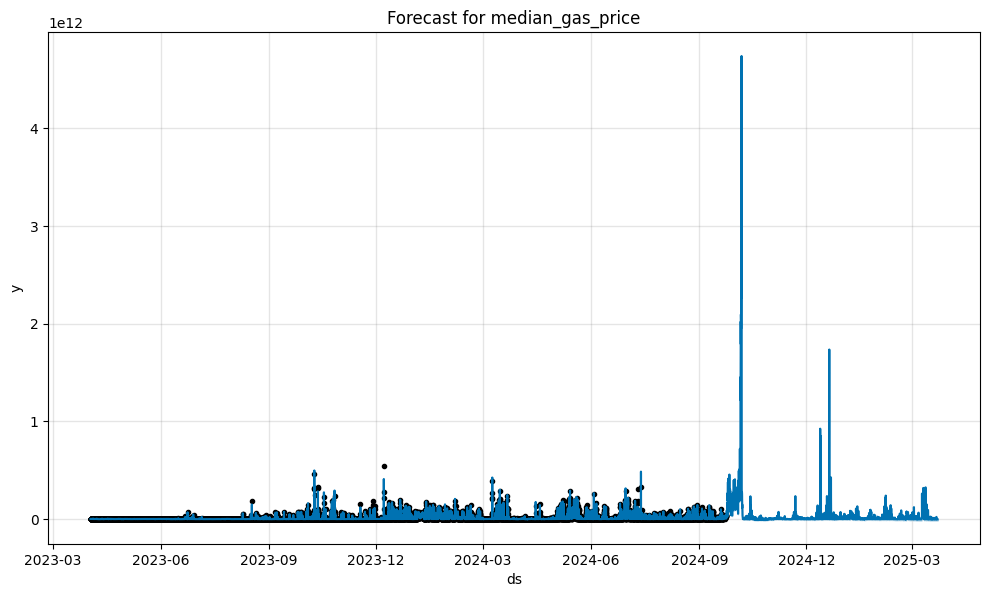

R² Score: 0.9960
MAE: 3232293406.6105
RMSE: 11414166103.1586
MAPE: 627.06%
{'r2_score': 0.9960396674741036, 'mae': 3232293406.6104803, 'rmse': np.float64(11414166103.158644), 'mape': np.float64(627.0601926047409)}


In [43]:
# Define regressors to use
regressor_columns = ["max_gas_price", "min_gas_price", "p25_gas_price", "p75_gas_price", 
                     "median_gas_price_7d", "median_gas_price_30d"]

# Train and evaluate Prophet with regressors
results,results_df = evaluate_prophet_with_regressors(df_gas, regressor_columns, train_size=0.75, freq='H',model_path=r'E:\Projects\gas_accountant\AI\prophet_model.pkl',save=False)

# Print results
print(results)


In [44]:
df_gas['y'] / 1e18

17299    1.501494e-09
17298    1.613547e-09
17297    1.841365e-09
17296    2.210777e-09
17295    1.605303e-09
             ...     
4        1.123705e-09
3        1.022745e-09
2        6.336744e-10
1        3.181253e-10
0        4.798578e-10
Name: y, Length: 17300, dtype: float64

In [45]:
results_df

,ds,max_gas_price,y,min_gas_price,p25_gas_price,p75_gas_price,median_gas_price_7d,median_gas_price_30d,yhat
0,2024-09-23 15:00:00,210000000000,2.677482e+10,19868653806,2.488919e+10,2.898364e+10,1.605896e+10,1.618032e+10,2.744034e+10
1,2024-09-23 16:00:00,4519917625048,2.434169e+10,14677769336,2.218114e+10,2.616317e+10,1.615115e+10,1.618671e+10,2.600693e+10
2,2024-09-23 17:00:00,221859509189,2.037334e+10,14169070184,1.765137e+10,2.372025e+10,1.616872e+10,1.618618e+10,1.994676e+10
3,2024-09-23 18:00:00,440825000000,2.392159e+10,14000000000,1.912594e+10,3.593837e+10,1.624960e+10,1.619492e+10,2.376021e+10
4,2024-09-23 19:00:00,339978735918,1.807272e+10,12178007696,1.648300e+10,1.960354e+10,1.631538e+10,1.619674e+10,1.859446e+10
...,...,...,...,...,...,...,...,...,...
4320,2025-03-22 15:00:00,2430000000000,1.123705e+09,2793677,5.522206e+06,1.503371e+09,2.818692e+09,2.058283e+10,-2.518181e+09
4321,2025-03-22 16:00:00,650000000000,1.022745e+09,2780586,5.250384e+06,1.503357e+09,2.779061e+09,2.052591e+10,-2.464505e+09
4322,2025-03-22 17:00:00,253400925441,6.336744e+08,2821181,4.954034e+06,1.503271e+09,2.717813e+09,2.052263e+10,-2.408821e+09
4323,2025-03-22 18:00:00,208736455613,3.181253e+08,2655729,4.750067e+06,1.503050e+09,2.684685e+09,2.051937e+10,-2.450270e+09


In [46]:
# from itertools import product
# from prophet import Prophet
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# def tune_prophet_hyperparameters(target_df, train_size=0.75, forecast_horizon=24, freq="H"):
#     """
#     Tunes Prophet's seasonality hyperparameters using a 75/25 train-test split.

#     Parameters:
#     - target_df: DataFrame containing ['ds', 'y'] columns.
#     - train_size: Proportion of data to use for training (default: 0.75).
#     - forecast_horizon: Number of future periods to forecast (default: 24).
#     - freq: Frequency of the dataset (default: 'H' for hourly data).

#     Returns:
#     - A dictionary with the best model, best parameters, and evaluation metrics.
#     """

#     # Sort data by date
#     target_df = target_df.sort_values("ds")

#     # Split into train (75%) and test (25%) based on `train_size`
#     split_idx = int(len(target_df) * train_size)
#     train_df = target_df.iloc[:split_idx]
#     test_df = target_df.iloc[split_idx:]

#     # Define parameter grid
#     param_grid = {
#         "yearly_seasonality": [True, False],
#         "weekly_seasonality": [True, False],
#         "daily_seasonality": [True, False],
#         "seasonality_mode": ["additive", "multiplicative"]
#     }

#     # Generate all possible parameter combinations
#     param_combinations = list(product(*param_grid.values()))

#     # Initialize best model tracking
#     best_mape = float("inf")
#     best_params = None
#     best_model = None
#     best_metrics = {}

#     for params in param_combinations:
#         try:
#             # Initialize Prophet model with given parameters
#             model = Prophet(
#                 yearly_seasonality=params[0],
#                 weekly_seasonality=params[1],
#                 daily_seasonality=params[2],
#                 seasonality_mode=params[3]
#             )
#             model.fit(train_df)  # Fit on training data

#             # Create future dataframe for the test period
#             future = model.make_future_dataframe(periods=len(test_df), freq=freq)
#             forecast = model.predict(future)

#             # Merge forecast with actual test values
#             merged_df = test_df.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

#             # Extract actual and predicted values
#             y_true = merged_df['y'].values
#             y_pred = merged_df['yhat'].values

#             # Compute evaluation metrics
#             r2 = r2_score(y_true, y_pred)
#             mae = mean_absolute_error(y_true, y_pred)
#             rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#             mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error

#             # Save best model if MAPE is lower
#             if mape < best_mape:
#                 best_mape = mape
#                 best_params = params
#                 best_model = model
#                 best_metrics = {"r2": r2, "mae": mae, "rmse": rmse, "mape": mape}

#         except Exception as e:
#             print(f"Error with parameters {params}: {e}")

#     # Print best parameters
#     print("Best Parameters:", dict(zip(param_grid.keys(), best_params)))
#     print(f"Best MAPE: {best_mape:.2f}%")
#     print(f"Best R² Score: {best_metrics['r2']:.4f}")
#     print(f"Best RMSE: {best_metrics['rmse']:.4f}")
#     print(f"Best MAE: {best_metrics['mae']:.4f}")

#     return {
#         "best_model": best_model,
#         "best_params": dict(zip(param_grid.keys(), best_params)),
#         "metrics": best_metrics
#     }


In [47]:
# best_result = tune_prophet_hyperparameters(target_df.reset_index())


In [48]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def create_chart(df, columns, title, y2_col=None, tickprefix=dict(y1=None, y2=None), ticksuffix=dict(y1=None, y2=None),show_legend=False,auto_title=True,show=True,save_directory=None):
    # Create a subplot with a secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Define the color cycle
    colors = ['blue', 'red', None]  # Blue, red, then default Plotly colors
    color_index = 0  # To track the current color in the cycle

    for col in columns:
        line_color = colors[color_index]  # Get the current color from the cycle
        color_index = (color_index + 1) % len(colors)  # Update to the next color, cycling back

        if col != y2_col:
            # Add traces to primary y-axis
            fig.add_trace(
                go.Scatter(
                    x=df.index,
                    y=df[col],
                    name=col.replace("_"," ").upper(),
                    line=dict(color=line_color) if line_color else {},
                    showlegend=show_legend
                ),
                secondary_y=False,  # Plot on primary y-axis
            )
        else:
            # Add traces to secondary y-axis
            fig.add_trace(
                go.Scatter(
                    x=df.index,
                    y=df[y2_col],
                    name=y2_col.replace("_"," ").upper(),
                    line=dict(color=line_color) if line_color else {},
                    showlegend=show_legend
                ),
                secondary_y=True,  # Plot on secondary y-axis
            )

    # Update the layout with titles
    fig.update_layout(
        title=title,
        xaxis_title="Date",
        legend=dict(x=0.01, y=0.99),
        template='plotly_white',
        hovermode='x unified',
        font=dict(color='black')
    )

    if auto_title:
        y1_title_text = columns[0].replace("_"," ").upper()
        y2_title_text = y2_col.replace("_"," ").upper() if y2_col else None
    else:
        y1_title_text = None
        y2_title_text = None

    # Set y-axes titles and colors
    fig.update_yaxes(title_text=y1_title_text, secondary_y=False, color='blue', tickprefix=tickprefix['y1'], ticksuffix=ticksuffix['y1'])
    fig.update_yaxes(title_text=y2_title_text, secondary_y=True, color='red', tickprefix=tickprefix['y2'], ticksuffix=ticksuffix['y2'])
    fig.update_xaxes(tickfont=dict(color='black'))

    # Show the plot
    if show:
        fig.show()

    return fig

In [49]:
y_fig = create_chart(results_df.set_index('ds'),['y','yhat'],title='Actual vs Predicted',auto_title=False,show_legend=True)

In [50]:
results_df.columns

Index(['ds', 'max_gas_price', 'y', 'min_gas_price', 'p25_gas_price',
       'p75_gas_price', 'median_gas_price_7d', 'median_gas_price_30d', 'yhat'],
      dtype='object')

In [53]:
model_path = os.path.join(base_cache_dir,'AI\prophet_model.pkl')
model_path

<>:1: SyntaxWarning:

invalid escape sequence '\p'

<>:1: SyntaxWarning:

invalid escape sequence '\p'

C:\Users\Brandyn\AppData\Local\Temp\ipykernel_16440\3080510646.py:1: SyntaxWarning:

invalid escape sequence '\p'



'c:\\Users\\Brandyn\\projects\\remote_gas_accountant\\AI\\prophet_model.pkl'

In [54]:
prophet_model = joblib.load(model_path)
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [53]:
# import os

# def update_prophet_model(df, model_path=r'E:\Projects\gas_accountant\AI\prophet_model.pkl', update_threshold=24):
#     """
#     Loads an existing Prophet model, updates it if new data is available, and saves it.

#     - update_threshold: Minimum number of new hours before refitting.
#     """
#     if os.path.exists(model_path):
#         prophet_model = joblib.load(model_path)
#         last_train_ds = prophet_model.history['ds'].max()
#     else:
#         prophet_model = Prophet()
#         last_train_ds = None

#     # Check if enough new data is available
#     new_data = df[df['ds'] > last_train_ds] if last_train_ds else df

#     if len(new_data) >= update_threshold:
#         print(f"🔄 Retraining model with {len(new_data)} new data points...")
#         prophet_model.fit(df)  # Retrain with updated data
#         joblib.dump(prophet_model, model_path)
#         print("✅ Model updated and saved!")
#     else:
#         print("✅ Using existing model (No significant new data).")

#     return prophet_model


In [55]:
import pandas as pd
import numpy as np
from prophet import Prophet

def forecast_gas_prices(model, df, regressors, start_date, train_hours=24, forecast_hours=24):
    """
    Uses an existing Prophet model trained on the last `train_hours` of data
    and forecasts `forecast_hours + any missing hours`, starting from the last data timestamp.

    Parameters:
    - model: A fitted Prophet model.
    - df: DataFrame containing historical gas price data.
    - regressors: List of additional columns to use as extra regressors.
    - train_hours: Number of hours to use for training (default: 24).
    - forecast_hours: Number of hours to forecast (default: 24).

    Returns:
    - Forecast DataFrame with predicted hourly gas prices.
    """

    # Ensure correct column names
    df = df.rename(columns={'hour': 'ds', 'median_gas_price': 'y'})

    # Sort data by timestamp
    df = df.sort_values('ds')

    # Get the last timestamp in the dataset
    last_timestamp = df['ds'].max()

    # Get current UTC time rounded to the nearest hour
    now_utc = pd.to_datetime(start_date)

    # Calculate the gap between now and the last data point
    time_gap = (now_utc - last_timestamp).total_seconds() / 3600  # Convert to hours

    # Adjust forecast hours to account for the missing gap
    adjusted_forecast_hours = forecast_hours + int(time_gap)

    print(f"📌 Last data point: {last_timestamp}")
    print(f"📌 Time gap to now: {time_gap:.1f} hours")
    print(f"📌 Forecasting {adjusted_forecast_hours} hours from {last_timestamp}")

    # Create future dataframe starting **right after the last data point**
    future_dates = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), 
                                 periods=adjusted_forecast_hours, freq='H')

    future = pd.DataFrame({'ds': future_dates})

    # ✅ Assign regressor values for future periods
    for reg in regressors:
        if reg in df.columns:
            # Use the last known regressor value
            future[reg] = df[reg].iloc[-1]

    # Predict
    forecast = model.predict(future)

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


In [56]:
short_term_sepolia_gas['hour'].max()

Timestamp('2025-03-22 19:00:00+0000', tz='UTC')

In [57]:
data_start_date = dt.datetime.now(dt.timezone.utc) - timedelta(hours=5)
data_start_date = data_start_date.strftime('%Y-%m-%d %H:00:00')

today_utc = dt.datetime.now(dt.timezone.utc) 
formatted_today_utc = today_utc.strftime('%Y-%m-%d %H:00:00')

In [58]:
# (pd.to_datetime(formatted_today_utc) - pd.to_datetime(short_term_sepolia_gas['hour'].max()))

In [59]:
pd.to_datetime(short_term_sepolia_gas['hour'].max())

Timestamp('2025-03-22 19:00:00+0000', tz='UTC')

In [60]:
forecast_sepolia = short_term_sepolia_gas.copy()

forecast_sepolia = forecast_sepolia.sort_values(by="hour")

# Compute rolling averages
forecast_sepolia["median_gas_price_7d"] = forecast_sepolia["median_gas_price"].rolling(window=7 * 24, min_periods=1).mean()
forecast_sepolia["median_gas_price_30d"] = forecast_sepolia["median_gas_price"].rolling(window=30 * 24, min_periods=1).mean()

# Drop NaN values (first few rows may have missing rolling averages)
forecast_sepolia.dropna(inplace=True)

forecast_sepolia= forecast_sepolia.rename(columns={"hour":"ds","median_gas_price":"y"}).copy()

# Print to check data structure
print(forecast_sepolia.head())

                          ds  max_gas_price             y  min_gas_price  \
43 2025-03-21 00:00:00+00:00   200000000000  1.969248e+07        2727357   
42 2025-03-21 01:00:00+00:00   200000000000  7.349040e+08        2958975   
41 2025-03-21 02:00:00+00:00   100000000000  1.051033e+09        2910691   
40 2025-03-21 03:00:00+00:00   252294746496  1.104580e+09        2918913   
39 2025-03-21 04:00:00+00:00  1151150000000  1.813647e+08        5880380   

    p25_gas_price  p75_gas_price  median_gas_price_7d  median_gas_price_30d  
43   4.910403e+06   1.503089e+09         1.969248e+07          1.969248e+07  
42   5.256760e+06   1.503441e+09         3.772982e+08          3.772982e+08  
41   6.957304e+06   1.504383e+09         6.018765e+08          6.018765e+08  
40   9.868163e+06   1.507118e+09         7.275524e+08          7.275524e+08  
39   1.355540e+07   1.509049e+09         6.183149e+08          6.183149e+08  


In [61]:
forecast_sepolia['ds'] = pd.to_datetime(forecast_sepolia['ds'])

In [62]:
short_term_sepolia_gas['hour'].iloc[-1]

Timestamp('2025-03-21 00:00:00+0000', tz='UTC')

In [63]:
# Convert the 'hour' column to UTC (removes timezone issues)
forecast_sepolia['ds'] = pd.to_datetime(forecast_sepolia['ds']
                                        ).dt.tz_localize(None)
forecast_sepolia
# Ensure `formatted_today_utc` is also in UTC
# formatted_today_utc = pd.Timestamp.utcnow().replace(minute=0, second=0, microsecond=0, tzinfo=pd.Timestamp.utcnow().tz)


,ds,max_gas_price,y,min_gas_price,p25_gas_price,p75_gas_price,median_gas_price_7d,median_gas_price_30d
43,2025-03-21 00:00:00,200000000000,1.969248e+07,2727357,4.910403e+06,1.503089e+09,1.969248e+07,1.969248e+07
42,2025-03-21 01:00:00,200000000000,7.349040e+08,2958975,5.256760e+06,1.503441e+09,3.772982e+08,3.772982e+08
41,2025-03-21 02:00:00,100000000000,1.051033e+09,2910691,6.957304e+06,1.504383e+09,6.018765e+08,6.018765e+08
40,2025-03-21 03:00:00,252294746496,1.104580e+09,2918913,9.868163e+06,1.507118e+09,7.275524e+08,7.275524e+08
39,2025-03-21 04:00:00,1151150000000,1.813647e+08,5880380,1.355540e+07,1.509049e+09,6.183149e+08,6.183149e+08
38,2025-03-21 05:00:00,1151150000000,4.435380e+08,2721424,9.211501e+06,1.505378e+09,5.891854e+08,5.891854e+08
37,2025-03-21 06:00:00,8894003720947,8.509682e+08,2905581,5.645319e+06,1.503504e+09,6.265829e+08,6.265829e+08
36,2025-03-21 07:00:00,1151150000000,1.092543e+09,5711483,1.436935e+07,1.511375e+09,6.848280e+08,6.848280e+08
35,2025-03-21 08:00:00,1151150000000,9.153295e+08,17450255,2.947117e+07,1.525324e+09,7.104392e+08,7.104392e+08
34,2025-03-21 09:00:00,1151150000000,1.422181e+09,32727951,1.178322e+08,1.599889e+09,7.816134e+08,7.816134e+08


In [64]:
short_term_sepolia_gas['hour'].max()

Timestamp('2025-03-22 19:00:00+0000', tz='UTC')

In [65]:
forecast_sepolia['ds'].max()

Timestamp('2025-03-22 19:00:00')

In [66]:
formatted_today_utc

'2025-03-22 20:00:00'

In [67]:
# Define regressors
regressor_columns = ["max_gas_price", "min_gas_price", "p25_gas_price", "p75_gas_price",
                     "median_gas_price_7d", "median_gas_price_30d"]

# ✅ Load or update the Prophet model
# model = update_prophet_model(forecast_sepolia, model_path=model_path, update_threshold=24)

# ✅ Forecast the next 24 hours, ensuring it starts from the **current hour**
forecast = forecast_gas_prices(prophet_model, forecast_sepolia,regressor_columns, start_date=formatted_today_utc, train_hours=24, forecast_hours=24)

# ✅ Display the forecast
# import matplotlib.pyplot as plt
# fig = prophet_model.plot(forecast)
# plt.title("Gas Price Forecast Up to the Current Hour")
# plt.show()

📌 Last data point: 2025-03-22 19:00:00
📌 Time gap to now: 1.0 hours
📌 Forecasting 25 hours from 2025-03-22 19:00:00


C:\Users\Brandyn\AppData\Local\Temp\ipykernel_16440\64528320.py:44: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [68]:
y_fig = create_chart(forecast.set_index('ds'),['yhat'],title=f"Predicted Gas Prices <br> Through {forecast['ds'].max()}",auto_title=False,show_legend=False,show=False)
y_fig.add_shape(
    type="line",
    x0=formatted_today_utc, x1=formatted_today_utc,
    y0=min(forecast['yhat']), y1=max(forecast['yhat']),
    line=dict(color="black", width=2, dash="dash")
)

In [69]:
short_term_sepolia_gas.columns

Index(['hour', 'max_gas_price', 'median_gas_price', 'min_gas_price',
       'p25_gas_price', 'p75_gas_price'],
      dtype='object')

In [70]:
update_historical_gas_data(short_term_sepolia_gas)

Updated historical_gas_data:
                         hour  max_gas_price  median_gas_price min_gas_price  \
0   2025-01-31 23:00:00+00:00   100000000000      1.975151e+09     901905452   
1   2025-01-31 22:00:00+00:00   100000000000      2.000216e+09     815791549   
2   2025-01-31 21:00:00+00:00   210000000000      2.858135e+09    1193908859   
3   2025-01-31 20:00:00+00:00   210000000000      3.130228e+09    1858195062   
4   2025-01-31 19:00:00+00:00   500000000000      7.116758e+09    1978633021   
..                        ...            ...               ...           ...   
137 2025-03-21 04:00:00+00:00  1151150000000      1.813647e+08       5880380   
138 2025-03-21 03:00:00+00:00   252294746496      1.104580e+09       2918913   
139 2025-03-21 02:00:00+00:00   100000000000      1.051033e+09       2910691   
140 2025-03-21 01:00:00+00:00   200000000000      7.349040e+08       2958975   
141 2025-03-21 00:00:00+00:00   200000000000      1.969248e+07       2727357   

     p25_g

In [71]:
historical_gas = cache.get(f'historical_gas_data')
historical_gas

,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price
0,2025-01-31 23:00:00+00:00,100000000000,1.975151e+09,901905452,1.224018e+09,2.485303e+09
1,2025-01-31 22:00:00+00:00,100000000000,2.000216e+09,815791549,1.259035e+09,2.527053e+09
2,2025-01-31 21:00:00+00:00,210000000000,2.858135e+09,1193908859,2.211837e+09,3.439532e+09
3,2025-01-31 20:00:00+00:00,210000000000,3.130228e+09,1858195062,2.491308e+09,3.632018e+09
4,2025-01-31 19:00:00+00:00,500000000000,7.116758e+09,1978633021,4.255715e+09,9.735677e+09
...,...,...,...,...,...,...
137,2025-03-21 04:00:00+00:00,1151150000000,1.813647e+08,5880380,1.355540e+07,1.509049e+09
138,2025-03-21 03:00:00+00:00,252294746496,1.104580e+09,2918913,9.868163e+06,1.507118e+09
139,2025-03-21 02:00:00+00:00,100000000000,1.051033e+09,2910691,6.957304e+06,1.504383e+09
140,2025-03-21 01:00:00+00:00,200000000000,7.349040e+08,2958975,5.256760e+06,1.503441e+09


In [74]:
forecast

,ds,yhat,yhat_lower,yhat_upper
0,2025-03-22 20:00:00,1.958343e+09,-5.113568e+09,8.542194e+09
1,2025-03-22 21:00:00,1.971971e+09,-4.782960e+09,8.821396e+09
2,2025-03-22 22:00:00,2.083117e+09,-5.082916e+09,8.864982e+09
3,2025-03-22 23:00:00,2.163324e+09,-4.611069e+09,9.453867e+09
4,2025-03-23 00:00:00,2.131622e+09,-4.783206e+09,9.053704e+09
5,2025-03-23 01:00:00,2.037332e+09,-4.785808e+09,8.198511e+09
6,2025-03-23 02:00:00,2.008789e+09,-4.933160e+09,9.327093e+09
7,2025-03-23 03:00:00,2.120449e+09,-5.045713e+09,8.586246e+09
8,2025-03-23 04:00:00,2.313678e+09,-4.563037e+09,8.889943e+09
9,2025-03-23 05:00:00,2.452438e+09,-4.444268e+09,8.991912e+09


In [72]:
update_forecast_gas_data(forecast.rename(columns={'ds':'hour'}))

Updated forecast_price_data:
                   hour          yhat    yhat_lower    yhat_upper  \
0   2025-02-01 00:00:00  3.155848e+09 -3.618736e+09  9.785774e+09   
1   2025-02-01 01:00:00  3.069880e+09 -2.870310e+09  9.900689e+09   
2   2025-02-01 02:00:00  3.049649e+09 -3.723416e+09  1.005953e+10   
3   2025-02-01 03:00:00  3.169427e+09 -3.421930e+09  1.026052e+10   
4   2025-02-01 04:00:00  3.370406e+09 -3.310814e+09  1.012925e+10   
..                  ...           ...           ...           ...   
169 2025-03-23 16:00:00  2.283767e+09 -4.827434e+09  8.992149e+09   
170 2025-03-23 17:00:00  2.331437e+09 -4.448978e+09  9.035187e+09   
171 2025-03-23 18:00:00  2.249193e+09 -4.307752e+09  9.539507e+09   
172 2025-03-23 19:00:00  2.081403e+09 -4.824140e+09  9.069381e+09   
173 2025-03-23 20:00:00  1.964074e+09 -5.311577e+09  8.907679e+09   

     median_gas_price  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN 

In [73]:
forecast_gas = cache.get(f'forecast_price_data')
forecast_gas

,hour,yhat,yhat_lower,yhat_upper,median_gas_price
0,2025-02-01 00:00:00,3.155848e+09,-3.618736e+09,9.785774e+09,NaN
1,2025-02-01 01:00:00,3.069880e+09,-2.870310e+09,9.900689e+09,NaN
2,2025-02-01 02:00:00,3.049649e+09,-3.723416e+09,1.005953e+10,NaN
3,2025-02-01 03:00:00,3.169427e+09,-3.421930e+09,1.026052e+10,NaN
4,2025-02-01 04:00:00,3.370406e+09,-3.310814e+09,1.012925e+10,NaN
...,...,...,...,...,...
169,2025-03-23 16:00:00,2.283767e+09,-4.827434e+09,8.992149e+09,NaN
170,2025-03-23 17:00:00,2.331437e+09,-4.448978e+09,9.035187e+09,NaN
171,2025-03-23 18:00:00,2.249193e+09,-4.307752e+09,9.539507e+09,NaN
172,2025-03-23 19:00:00,2.081403e+09,-4.824140e+09,9.069381e+09,NaN


# Tracking the Test Protocol Gas Reverse

Current block number: 7655478


In [74]:
GAS_RESERVE

'0x21229F20F71882Fb61AD31Fe5501FAe26C621830'

## We can track internal TX of gas reserve contract to see how much it spends

In [76]:
# # tx_history = get_tx_with_pagination(GAS_RESERVE, current_block - 10000, current_block - 1, ETHERSCAN_KEY)
# internal_tx_history = get_tx_and_log_with_pagination(GAS_RESERVE, last_from_block, 'latest', ETHERSCAN_KEY, action='txlistinternal')

# if len(internal_tx_history) > 0:

#     processed_transactions = [process_transaction(tx) for tx in internal_tx_history]
    
#     # Convert to DataFrame
#     df = pd.DataFrame(processed_transactions)
    
#     dataset = df.copy()
#     dataset = dataset[dataset['from']==GAS_RESERVE.lower()]
#     dataset['hour'] = dataset['timestamp'].dt.strftime('%Y-%m-%d %H:00:00')
    
#     earliest_date = dataset['hour'].min()
    
#     eth_query = token_prices(['0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'],'ethereum',earliest_date)
#     eth_df = flipside_api_results(api_key=FLIPSIDE_API_KEY,query=eth_query)
#     eth_df['hour'] = pd.to_datetime(eth_df['hour']).dt.strftime('%Y-%m-%d %H:00:00')
#     eth_df.set_index('hour',inplace=True)
#     eth_df_wide = data_processing(eth_df.reset_index())
#     eth_df_wide.index = eth_df_wide.index.strftime('%Y-%m-%d %H:00:00')
#     update_eth_price_data(eth_df_wide)

Fetched 1 txs from page 1.
All txs fetched.
Beginning: '2025-02-07 01:00:00'
cleaning prices
cleaned prices:                     dt  WETH_price
0  2025-02-07 01:00:00     2681.46
DatetimeIndex(['2025-02-07 01:00:00'], dtype='datetime64[ns]', name='dt', freq=None)


### Here we combine gas history to get full tx history

In [ ]:
# short_term_sepolia_gas['hour'] = pd.to_datetime(short_term_sepolia_gas['hour']).dt.strftime('%Y-%m-%d %H:00:00')
# dataset_merged = dataset.merge(
#     short_term_sepolia_gas,
#     on='hour',
#     how='left'
# )
# print(dataset)

In [ ]:
# dataset_merged['hour']

0    2025-02-01 04:00:00
Name: hour, dtype: object

In [ ]:
# dataset_merged['gasPrice'] = dataset_merged['gasPrice'].fillna(dataset_merged['median_gas_price'])
# dataset_merged['tx_fee'] = dataset_merged['tx_fee'].fillna((dataset_merged['gasPrice'] * dataset_merged['gasUsed']) / 1e18)

In [ ]:
# eth_df_wide.reset_index(inplace=True)
# eth_df_wide.rename(columns={'dt':'hour'},inplace=True)

In [ ]:
# dataset_merged

,blockNumber,timestamp,transaction_hash,from,to,gas,gasPrice,gasUsed,tx_fee,contractAddress,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price
0,7615059,2025-02-01 04:52:36,0xd72c0de7ae029174fe9d87e2e38d33e418272b236297...,0xf8d1f97053376a853a6856b1272be5ce1036fea1,0x3e3a83ac9dc9fd078aee45caf91626ecad6336cf,2300,NaN,55,NaN,,2025-02-01 04:00:00,NaN,NaN,NaN,NaN,NaN


In [ ]:
# eth_df_wide.columns

Index(['hour', 'WETH_price'], dtype='object')

In [ ]:
# dataset

,blockNumber,timestamp,transaction_hash,from,to,gas,gasPrice,gasUsed,tx_fee,contractAddress,hour
0,7615059,2025-02-01 04:52:36,0xd72c0de7ae029174fe9d87e2e38d33e418272b236297...,0xf8d1f97053376a853a6856b1272be5ce1036fea1,0x3e3a83ac9dc9fd078aee45caf91626ecad6336cf,2300,NaN,55,NaN,,2025-02-01 04:00:00


In [ ]:
# dataset_merged=dataset_merged.merge(
#     eth_df_wide,
#     on='hour',
#     how='left'
# )

In [ ]:
# dataset_merged['tx_fee_usd'] = dataset_merged['tx_fee'] * dataset_merged['WETH_price']
# dataset_merged['tx_fee_usd']

0   NaN
Name: tx_fee_usd, dtype: float64

In [ ]:
# dataset_merged['transaction_hash'].values[0]

'0xd72c0de7ae029174fe9d87e2e38d33e418272b2362977db1d4623fd0b916f61a'

In [ ]:
#USE logs instead

# update_contract_data(dataset_merged)

## We can also read the event logs to see gas requested, requester, and time requested

In [ ]:
# w3.eth.block_number

7642211

In [ ]:
# logs = get_tx_and_log_with_pagination(GAS_RESERVE, w3.eth.block_number - 1000000, w3.eth.block_number, ETHERSCAN_KEY,module='logs', action='getLogs')

Fetched 1 logs from page 1.
All logs fetched.


In [ ]:
# parsed_logs = [parse_gas_log(log) for log in logs]
# for log in parsed_logs:
#     print(log)

{'timestamp': datetime.datetime(2025, 2, 1, 4, 52, 36), 'transaction_hash': '0xd72c0de7ae029174fe9d87e2e38d33e418272b2362977db1d4623fd0b916f61a', 'requester': '0x3e3a83ac9dc9fd078aee45caf91626ecad6336cf', 'gas_amount_eth': 0.0002}


In [ ]:
# df = pd.DataFrame(parsed_logs)

# # Convert timestamp to datetime format
# df["timestamp"] = pd.to_datetime(df["timestamp"])

# # Set timestamp as the index
# df.set_index("timestamp", inplace=True)

# # Sort by timestamp
# df = df.sort_index()

# # Display the first few rows
# print(df.head())

# df.reset_index(inplace=True)
# df['hour'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:00:00')

# df_merged = df.merge(
#     short_term_sepolia_gas,
#     on='hour',
#     how='left'
# )
# print(df_merged)

# df_merged=df_merged.merge(
#     eth_df_wide,
#     on='hour',
#     how='left'
# )

                                                      transaction_hash  \
timestamp                                                                
2025-02-01 04:52:36  0xd72c0de7ae029174fe9d87e2e38d33e418272b236297...   

                                                      requester  \
timestamp                                                         
2025-02-01 04:52:36  0x3e3a83ac9dc9fd078aee45caf91626ecad6336cf   

                     gas_amount_eth  
timestamp                            
2025-02-01 04:52:36          0.0002  
            timestamp                                   transaction_hash  \
0 2025-02-01 04:52:36  0xd72c0de7ae029174fe9d87e2e38d33e418272b236297...   

                                    requester  gas_amount_eth  \
0  0x3e3a83ac9dc9fd078aee45caf91626ecad6336cf          0.0002   

                  hour max_gas_price  median_gas_price min_gas_price  \
0  2025-02-01 04:00:00           NaN               NaN           NaN   

   p25_gas_price  p75_gas_price 

In [ ]:
# df_merged['address'] = GAS_RESERVE

In [ ]:
# update_contract_data(df_merged)

new data:             timestamp                                   transaction_hash  \
0 2025-02-01 04:52:36  0xd72c0de7ae029174fe9d87e2e38d33e418272b236297...   

                                    requester  gas_amount_eth  \
0  0x3e3a83ac9dc9fd078aee45caf91626ecad6336cf          0.0002   

                  hour max_gas_price  median_gas_price min_gas_price  \
0  2025-02-01 04:00:00           NaN               NaN           NaN   

   p25_gas_price  p75_gas_price  WETH_price  \
0            NaN            NaN      3312.5   

                                      address  
0  0xf8d1f97053376a853A6856B1272BE5cE1036Fea1  
model actions before update:             timestamp                                   transaction_hash  \
0 2025-02-01 04:52:36  0xd72c0de7ae029174fe9d87e2e38d33e418272b236297...   

                                    requester  gas_amount_eth  \
0  0x3e3a83ac9dc9fd078aee45caf91626ecad6336cf          0.0002   

                  hour max_gas_price  median_gas_price mi

C:\Users\brandyns pc\AppData\Local\Temp\ipykernel_20868\1263147255.py:67: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



## Here we combine gas history to get full tx history

# Tracking AI Agent Gas Costs

In [75]:
current_block = w3.eth.block_number
print(f"Current block number: {current_block}")

Current block number: 7958981


In [76]:
last_from_block = cache.get('last_from_block',None)

if last_from_block is None:
    last_from_block = current_block - 7500000

last_from_block

7655575

In [77]:
addresses = [BOT_1_ADDRESS,BOT_2_ADDRESS]
addresses_lower = [addr.lower() for addr in addresses]

address_df = pd.DataFrame()

for address in addresses:
    tx_history = get_tx_and_log_with_pagination(address, last_from_block - 10000000000, 'latest', ETHERSCAN_KEY)

    processed_transactions = [process_transaction(tx) for tx in tx_history]

    # Convert to DataFrame
    df = pd.DataFrame(processed_transactions)

    address_df = pd.concat([address_df,df])

Fetched 50 txs from page 1.
All txs fetched.


C:\Users\Brandyn\AppData\Local\Temp\ipykernel_16440\1092977763.py:7: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).



Fetched 16 txs from page 1.
All txs fetched.


In [78]:
cache.set('last_from_block',current_block)

True

In [79]:
address_df

,blockNumber,timestamp,transaction_hash,from,to,gas,gasPrice,gasUsed,tx_fee,contractAddress
0,7639402,2025-02-04 16:51:36,0xa6cc6cafd2b395e3d003582c2316275960e94a9af9b7...,0x2102240d1a36a9dc9f3a4d07ee9251cb723aca89,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,21000,3.163814e+10,21000,0.000664,
1,7641377,2025-02-04 23:50:48,0xa6bc3d7ccb6ee505bf1ac5aeadaab3c9946622fd3e92...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,2.000000e+10,34504,0.000690,
2,7641863,2025-02-05 01:35:48,0xb7644d83cf9e184a7e013d314f88bffa9d76b7322957...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,2.000000e+10,34504,0.000690,
3,7641884,2025-02-05 01:40:00,0xe01a44ff892b75134227197aa96c34c226f5347f3125...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863,2.000000e+10,34504,0.000690,
4,7641895,2025-02-05 01:42:36,0x39378833b2094a5c08c0973d72168c86ed9b5bbffcb4...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,2.000000e+10,34504,0.000690,
...,...,...,...,...,...,...,...,...,...,...
11,7654899,2025-02-06 23:59:36,0x61600e6f2fea437dd528598d4892908d846b3a3ff7f4...,0xc26204ece1f23d993200e31a5c68bd58ddd0c6b6,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863,2.000000e+10,34504,0.000690,
12,7655743,2025-02-07 03:00:12,0xd4396a1ed3bc34d12b99dc6ec080df36eee0c6c63d70...,0xc26204ece1f23d993200e31a5c68bd58ddd0c6b6,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,3.706515e+10,34504,0.001279,
13,7656607,2025-02-07 05:59:36,0x1c9f7f8abeebbedcbce1fedbf2ddce4bb915483c95bf...,0xc26204ece1f23d993200e31a5c68bd58ddd0c6b6,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863,2.000000e+10,34504,0.000690,
14,7657466,2025-02-07 09:00:00,0x1cdea004325b6a368e78b9e66be97cb7a01e388ab658...,0xc26204ece1f23d993200e31a5c68bd58ddd0c6b6,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863,7.136705e+10,34504,0.002462,


In [80]:
addresses_lower

['0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8',
 '0xc26204ece1f23d993200e31a5c68bd58ddd0c6b6']

In [81]:
dataset = address_df.copy()
dataset = dataset[dataset['from'].str.lower().isin(addresses_lower)]
dataset['hour'] = dataset['timestamp'].dt.strftime('%Y-%m-%d %H:00:00')

In [82]:
dataset

,blockNumber,timestamp,transaction_hash,from,to,gas,gasPrice,gasUsed,tx_fee,contractAddress,hour
1,7641377,2025-02-04 23:50:48,0xa6bc3d7ccb6ee505bf1ac5aeadaab3c9946622fd3e92...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,2.000000e+10,34504,0.000690,,2025-02-04 23:00:00
2,7641863,2025-02-05 01:35:48,0xb7644d83cf9e184a7e013d314f88bffa9d76b7322957...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,2.000000e+10,34504,0.000690,,2025-02-05 01:00:00
3,7641884,2025-02-05 01:40:00,0xe01a44ff892b75134227197aa96c34c226f5347f3125...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863,2.000000e+10,34504,0.000690,,2025-02-05 01:00:00
4,7641895,2025-02-05 01:42:36,0x39378833b2094a5c08c0973d72168c86ed9b5bbffcb4...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,2.000000e+10,34504,0.000690,,2025-02-05 01:00:00
5,7641983,2025-02-05 02:01:36,0x3a851b75c41d276d1a043a910ab5c910346c3043b76e...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,2.000000e+10,34504,0.000690,,2025-02-05 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...
11,7654899,2025-02-06 23:59:36,0x61600e6f2fea437dd528598d4892908d846b3a3ff7f4...,0xc26204ece1f23d993200e31a5c68bd58ddd0c6b6,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863,2.000000e+10,34504,0.000690,,2025-02-06 23:00:00
12,7655743,2025-02-07 03:00:12,0xd4396a1ed3bc34d12b99dc6ec080df36eee0c6c63d70...,0xc26204ece1f23d993200e31a5c68bd58ddd0c6b6,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,3.706515e+10,34504,0.001279,,2025-02-07 03:00:00
13,7656607,2025-02-07 05:59:36,0x1c9f7f8abeebbedcbce1fedbf2ddce4bb915483c95bf...,0xc26204ece1f23d993200e31a5c68bd58ddd0c6b6,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863,2.000000e+10,34504,0.000690,,2025-02-07 05:00:00
14,7657466,2025-02-07 09:00:00,0x1cdea004325b6a368e78b9e66be97cb7a01e388ab658...,0xc26204ece1f23d993200e31a5c68bd58ddd0c6b6,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863,7.136705e+10,34504,0.002462,,2025-02-07 09:00:00


In [83]:
earliest_date = cache.get('earliest_date',None)

if earliest_date is None:

    earliest_date = dataset['hour'].min()

In [84]:
earliest_date

'2025-02-04 23:00:00'

In [85]:
eth_query = token_prices(['0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'],'ethereum',earliest_date)
eth_df = flipside_api_results(api_key=FLIPSIDE_API_KEY,query=eth_query)
eth_df['hour'] = pd.to_datetime(eth_df['hour']).dt.strftime('%Y-%m-%d %H:00:00')
eth_df.set_index('hour',inplace=True)
eth_df_wide = data_processing(eth_df.reset_index())
eth_df_wide.index = eth_df_wide.index.strftime('%Y-%m-%d %H:00:00')
update_eth_price_data(eth_df_wide)

Beginning: '2025-02-04 23:00:00'


KeyError: 'message'

In [109]:
cache.get('earliest_date',eth_df_wide.index.max())

'2025-02-07 02:00:00'

In [118]:
historical_gas

,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price
0,2025-01-31 23:00:00+00:00,100000000000,1.975151e+09,901905452,1.224018e+09,2.485303e+09
1,2025-01-31 22:00:00+00:00,100000000000,2.000216e+09,815791549,1.259035e+09,2.527053e+09
2,2025-01-31 21:00:00+00:00,210000000000,2.858135e+09,1193908859,2.211837e+09,3.439532e+09
3,2025-01-31 20:00:00+00:00,210000000000,3.130228e+09,1858195062,2.491308e+09,3.632018e+09
4,2025-01-31 19:00:00+00:00,500000000000,7.116758e+09,1978633021,4.255715e+09,9.735677e+09
...,...,...,...,...,...,...
93,2025-02-06 04:00:00+00:00,300000000000,2.626192e+09,921879598,1.991853e+09,3.431919e+09
94,2025-02-06 03:00:00+00:00,300000000000,2.724845e+09,1033747114,1.979493e+09,3.201692e+09
95,2025-02-06 02:00:00+00:00,201056451432,2.388599e+09,955068260,1.673999e+09,2.981940e+09
96,2025-02-06 01:00:00+00:00,1000000000000,2.100982e+09,826258065,1.222574e+09,2.545729e+09


In [119]:
historical_gas['hour'] = pd.to_datetime(historical_gas['hour']).dt.strftime('%Y-%m-%d %H:00:00')
dataset_merged = dataset.merge(
    historical_gas,
    on='hour',
    how='left'
)
print(dataset_merged)

    blockNumber           timestamp  \
0       7641377 2025-02-04 23:50:48   
1       7641863 2025-02-05 01:35:48   
2       7641884 2025-02-05 01:40:00   
3       7641895 2025-02-05 01:42:36   
4       7641983 2025-02-05 02:01:36   
5       7642545 2025-02-05 03:59:48   
6       7646851 2025-02-05 19:27:36   
7       7647000 2025-02-05 19:59:36   
8       7647281 2025-02-05 20:59:48   
9       7647556 2025-02-05 21:59:36   
10      7647835 2025-02-05 22:59:36   
11      7648114 2025-02-05 23:59:36   
12      7648402 2025-02-06 00:59:48   
13      7648681 2025-02-06 01:59:48   
14      7648967 2025-02-06 02:59:36   
15      7649253 2025-02-06 03:59:36   
16      7649529 2025-02-06 04:59:48   
17      7649810 2025-02-06 05:59:36   
18      7650091 2025-02-06 06:59:36   
19      7650376 2025-02-06 07:59:36   
20      7650658 2025-02-06 08:59:36   
21      7650937 2025-02-06 10:00:00   
22      7651222 2025-02-06 10:59:36   
23      7651511 2025-02-06 11:59:48   
24      7652057 2025-02-0

In [120]:
dataset_merged

,blockNumber,timestamp,transaction_hash,from,to,gas,gasPrice,gasUsed,tx_fee,contractAddress,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price
0,7641377,2025-02-04 23:50:48,0xa6bc3d7ccb6ee505bf1ac5aeadaab3c9946622fd3e92...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,2.000000e+10,34504,0.000690,,2025-02-04 23:00:00,2983892099615,2.032516e+09,861112041,1.207765e+09,2.533816e+09
1,7641863,2025-02-05 01:35:48,0xb7644d83cf9e184a7e013d314f88bffa9d76b7322957...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,2.000000e+10,34504,0.000690,,2025-02-05 01:00:00,NaN,NaN,NaN,NaN,NaN
2,7641884,2025-02-05 01:40:00,0xe01a44ff892b75134227197aa96c34c226f5347f3125...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863,2.000000e+10,34504,0.000690,,2025-02-05 01:00:00,NaN,NaN,NaN,NaN,NaN
3,7641895,2025-02-05 01:42:36,0x39378833b2094a5c08c0973d72168c86ed9b5bbffcb4...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,2.000000e+10,34504,0.000690,,2025-02-05 01:00:00,NaN,NaN,NaN,NaN,NaN
4,7641983,2025-02-05 02:01:36,0x3a851b75c41d276d1a043a910ab5c910346c3043b76e...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,2.000000e+10,34504,0.000690,,2025-02-05 02:00:00,NaN,NaN,NaN,NaN,NaN
5,7642545,2025-02-05 03:59:48,0xdffe079a2ad92549641db2c1e72824d437576a294571...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x3fc47744b859e08c59b71c883bdc204eba100b60,34875,2.000000e+10,34516,0.000690,,2025-02-05 03:00:00,NaN,NaN,NaN,NaN,NaN
6,7646851,2025-02-05 19:27:36,0x3ad7f6d2139ca3ee47ed45d7733a84e9a745671c2426...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863,2.367705e+10,34504,0.000817,,2025-02-05 19:00:00,NaN,NaN,NaN,NaN,NaN
7,7647000,2025-02-05 19:59:36,0x1b6210715a1444b1a261fa3584cc32e390b239f4ee94...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863,2.000000e+10,34504,0.000690,,2025-02-05 19:00:00,NaN,NaN,NaN,NaN,NaN
8,7647281,2025-02-05 20:59:48,0x205da71def2b3ea3933473fbba140380f316b429d62c...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863,2.000000e+10,34504,0.000690,,2025-02-05 20:00:00,NaN,NaN,NaN,NaN,NaN
9,7647556,2025-02-05 21:59:36,0xb6190248c945cbcb330e06aeaa19b2234c3fca32660f...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863,2.000000e+10,34504,0.000690,,2025-02-05 21:00:00,NaN,NaN,NaN,NaN,NaN


In [121]:
forecast_gas['hour'] = forecast_gas['hour'].astype('str')

In [158]:
dataset_merged = dataset.merge(
    forecast_gas[['hour','yhat']],
    on='hour',
    how='left'
)
print(dataset_merged)

    blockNumber           timestamp  \
0       7641377 2025-02-04 23:50:48   
1       7641863 2025-02-05 01:35:48   
2       7641884 2025-02-05 01:40:00   
3       7641895 2025-02-05 01:42:36   
4       7641983 2025-02-05 02:01:36   
5       7642545 2025-02-05 03:59:48   
6       7646851 2025-02-05 19:27:36   
7       7647000 2025-02-05 19:59:36   
8       7647281 2025-02-05 20:59:48   
9       7647556 2025-02-05 21:59:36   
10      7647835 2025-02-05 22:59:36   
11      7648114 2025-02-05 23:59:36   
12      7648402 2025-02-06 00:59:48   
13      7648681 2025-02-06 01:59:48   
14      7648967 2025-02-06 02:59:36   
15      7649253 2025-02-06 03:59:36   
16      7649529 2025-02-06 04:59:48   
17      7649810 2025-02-06 05:59:36   
18      7650091 2025-02-06 06:59:36   
19      7650376 2025-02-06 07:59:36   
20      7650658 2025-02-06 08:59:36   
21      7650937 2025-02-06 10:00:00   
22      7651222 2025-02-06 10:59:36   
23      7651511 2025-02-06 11:59:48   
24      7652057 2025-02-0

In [159]:
update_contract_data(dataset_merged)

new data:     blockNumber           timestamp  \
0       7641377 2025-02-04 23:50:48   
1       7641863 2025-02-05 01:35:48   
2       7641884 2025-02-05 01:40:00   
3       7641895 2025-02-05 01:42:36   
4       7641983 2025-02-05 02:01:36   
5       7642545 2025-02-05 03:59:48   
6       7646851 2025-02-05 19:27:36   
7       7647000 2025-02-05 19:59:36   
8       7647281 2025-02-05 20:59:48   
9       7647556 2025-02-05 21:59:36   
10      7647835 2025-02-05 22:59:36   
11      7648114 2025-02-05 23:59:36   
12      7648402 2025-02-06 00:59:48   
13      7648681 2025-02-06 01:59:48   
14      7648967 2025-02-06 02:59:36   
15      7649253 2025-02-06 03:59:36   
16      7649529 2025-02-06 04:59:48   
17      7649810 2025-02-06 05:59:36   
18      7650091 2025-02-06 06:59:36   
19      7650376 2025-02-06 07:59:36   
20      7650658 2025-02-06 08:59:36   
21      7650937 2025-02-06 10:00:00   
22      7651222 2025-02-06 10:59:36   
23      7651511 2025-02-06 11:59:48   
24      7652057

# Burn Rate Calculations

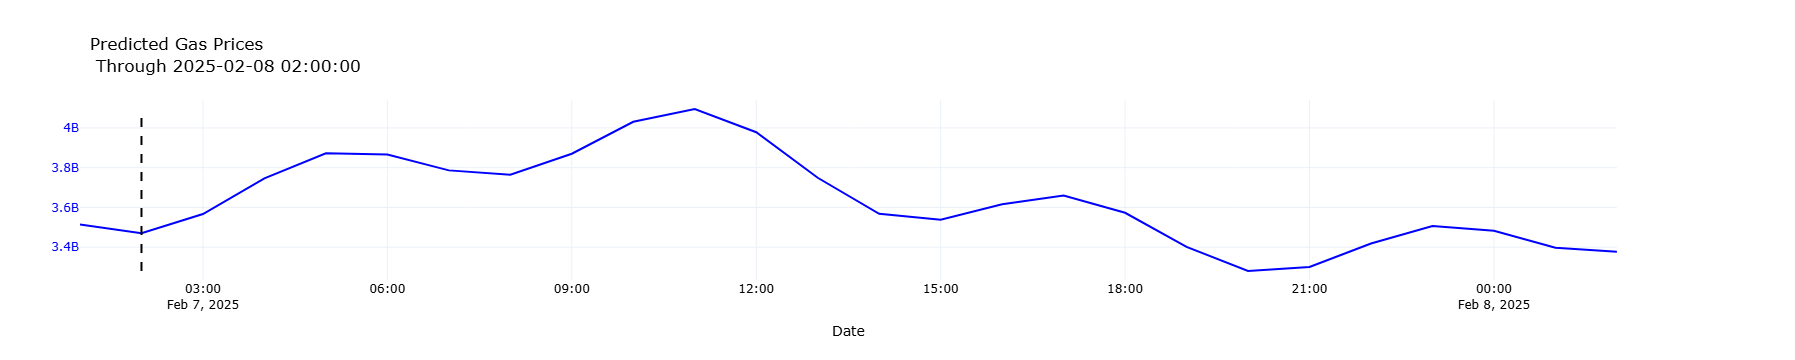

In [160]:
y_fig

In [171]:
contract_data = cache.get(f'contract_data')

balance_data = cache.get(f'balance_data')

forecast_data = cache.get('forecast_price_data')

In [172]:
balance_data

,account,balance,balance_ETH,hour
0,0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89,799699418042698592,0.799699,2025-02-01 03:00:00
1,0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89,742819206854221013,0.742819,2025-02-01 05:00:00
2,0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89,245929182129654475,0.245929,2025-02-07 02:00:00


In [168]:
contract_data

,blockNumber,timestamp,transaction_hash,from,to,gas,gasPrice,gasUsed,tx_fee,contractAddress,...,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price,WETH_price,tx_fee_usd,requester,gas_amount_eth,address,yhat
0,7612904.0,2025-01-31 21:28:24,0xaf8ab04470639668568878222952df0a4a44bc10cb6e...,0x0064c627a55aef07f4ab6fea62e516a76e38ac8a,0x0448d01970801692c22ff2eccc570f2f7cd9b889,2300.0,2.858135e+09,55.0,1.571974e-07,,...,2.858135e+09,1.193909e+09,2.211837e+09,3.439532e+09,3322.87,0.000522,NaN,NaN,NaN,NaN
1,NaN,2025-02-01 03:50:48,0xdf9aac8e3a1dbd9d194bc43bf3350c628731d84f0894...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3319.46,NaN,0x0448d01970801692c22ff2eccc570f2f7cd9b889,0.0100,NaN,NaN
2,NaN,2025-02-01 04:52:36,0xd72c0de7ae029174fe9d87e2e38d33e418272b236297...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3312.50,NaN,0x3e3a83ac9dc9fd078aee45caf91626ecad6336cf,0.0002,0xf8d1f97053376a853A6856B1272BE5cE1036Fea1,NaN
3,7641377.0,2025-02-04 23:50:48,0xa6bc3d7ccb6ee505bf1ac5aeadaab3c9946622fd3e92...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863.0,2.000000e+10,34504.0,6.900800e-04,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.431357e+09
4,7641863.0,2025-02-05 01:35:48,0xb7644d83cf9e184a7e013d314f88bffa9d76b7322957...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863.0,2.000000e+10,34504.0,6.900800e-04,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.341100e+09
7,7641983.0,2025-02-05 02:01:36,0x3a851b75c41d276d1a043a910ab5c910346c3043b76e...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863.0,2.000000e+10,34504.0,6.900800e-04,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.331598e+09
8,7642545.0,2025-02-05 03:59:48,0xdffe079a2ad92549641db2c1e72824d437576a294571...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x3fc47744b859e08c59b71c883bdc204eba100b60,34875.0,2.000000e+10,34516.0,6.903200e-04,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.462844e+09
9,7646851.0,2025-02-05 19:27:36,0x3ad7f6d2139ca3ee47ed45d7733a84e9a745671c2426...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863.0,2.367705e+10,34504.0,8.169531e-04,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.653402e+09
11,7647281.0,2025-02-05 20:59:48,0x205da71def2b3ea3933473fbba140380f316b429d62c...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x86ce29079cc2b017dbf3285fce40c911000a0f45,34863.0,2.000000e+10,34504.0,6.900800e-04,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.536851e+09
12,7647556.0,2025-02-05 21:59:36,0xb6190248c945cbcb330e06aeaa19b2234c3fca32660f...,0x21efbee92e732d9d87ae7b67e0aae7a972bd23f8,0x3fc47744b859e08c59b71c883bdc204eba100b60,34863.0,2.000000e+10,34504.0,6.900800e-04,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.559184e+09


In [163]:
burn_rate = contract_data['gas_amount_eth'].mean()

In [164]:
balance = balance_data['balance_ETH'].values[0]

In [165]:
burn_rate_ratio = abs(contract_data['gas_amount_eth'].mean()) / (balance_data['balance_ETH'].values[0] / (365*24)) 
burn_rate_ratio

55.86599038592098

In [166]:
sustainable_ceiling = balance_data['balance_ETH'].values[0] / (365*24)

In [167]:
# 1️⃣ Calculate average hourly ETH spent on gas
hourly_gas_spent = abs(contract_data['gas_amount_eth'].mean())

# 2️⃣ Calculate total ETH balance
eth_balance = balance_data['balance_ETH'].values[0]

# 3️⃣ Calculate ETH cash runway (hours)
eth_runway_hours = eth_balance / hourly_gas_spent

# 4️⃣ Convert to days, months, and years
eth_runway_days = eth_runway_hours / 24
eth_runway_months = eth_runway_days / 30
eth_runway_years = eth_runway_months / 12

# 5️⃣ Burn rate ratio: ETH spent per hour compared to sustainable ETH burn
burn_rate_ratio = hourly_gas_spent / (eth_balance / (365 * 24))

# ✅ Print results
print(f"ETH Burn Rate: {hourly_gas_spent}")
print(f'ETH Balance {eth_balance}')
print(f"Sustainable Ceiling: {sustainable_ceiling}")
print(f"ETH Gas Runway: {eth_runway_hours:.2f} hours")
print(f"ETH Gas Runway: {eth_runway_days:.2f} days")
print(f"ETH Gas Runway: {eth_runway_months:.2f} months")
print(f"ETH Gas Runway: {eth_runway_years:.2f} years")
print(f"ETH Burn Rate Ratio: {burn_rate_ratio:.4f}")


ETH Burn Rate: 0.0051
ETH Balance 0.7996994180426986
Sustainable Ceiling: 9.128988790441765e-05
ETH Gas Runway: 156.80 hours
ETH Gas Runway: 6.53 days
ETH Gas Runway: 0.22 months
ETH Gas Runway: 0.02 years
ETH Burn Rate Ratio: 55.8660


In [169]:
balance_data

,account,balance,balance_ETH,hour
0,0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89,799699418042698592,0.799699,2025-02-01 03:00:00
1,0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89,742819206854221013,0.742819,2025-02-01 05:00:00
2,0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89,245929182129654475,0.245929,2025-02-07 02:00:00


In [135]:
burn_rate_ratio_timeseries = {
    'date':formatted_today_utc,
    'burn_rate_ratio':burn_rate_ratio,
    'burn_rate ETH (avg hourly spend)':contract_data['gas_amount_eth'].mean(),
    'balance': balance_data['balance_ETH'].values[0]
}

In [136]:
pd.DataFrame([burn_rate_ratio_timeseries])

,date,burn_rate_ratio,burn_rate ETH (avg hourly spend),balance
0,2025-02-07 02:00:00,55.86599,0.0051,0.799699


In [137]:
dataset_merged.columns

Index(['blockNumber', 'timestamp', 'transaction_hash', 'from', 'to', 'gas',
       'gasPrice', 'gasUsed', 'tx_fee', 'contractAddress', 'hour', 'yhat'],
      dtype='object')

In [138]:
dataset_merged[['tx_fee_usd','tx_fee']]

KeyError: "['tx_fee_usd'] not in index"

In [140]:
eth_data = get_eth_balances(ETHERSCAN_KEY, [ACCOUNT_ADDRESS,BOT_1_ADDRESS,BOT_2_ADDRESS])

In [142]:
eth_data

{'status': '1',
 'message': 'OK',
 'result': [{'account': '0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89',
   'balance': '245929182129654475'},
  {'account': '0x21efbeE92E732D9d87Ae7b67E0aae7a972bd23F8',
   'balance': '28898211754361431'},
  {'account': '0xc26204ecE1f23d993200E31A5C68bD58DDd0c6b6',
   'balance': '84182291127744928'}]}

In [143]:
pd.DataFrame(eth_data['result'])

,account,balance
0,0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89,245929182129654475
1,0x21efbeE92E732D9d87Ae7b67E0aae7a972bd23F8,28898211754361431
2,0xc26204ecE1f23d993200E31A5C68bD58DDd0c6b6,84182291127744928


In [146]:
current_balances = pd.DataFrame(eth_data['result'])
current_balances['balance'] = pd.to_numeric(current_balances['balance'], errors='coerce')

# Convert from wei to ETH
current_balances['balance_ETH'] = current_balances['balance'] / 1e18

In [147]:
current_balances['hour'] = formatted_today_utc

In [148]:
current_balances

,account,balance,balance_ETH,hour
0,0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89,245929182129654475,0.245929,2025-02-07 02:00:00
1,0x21efbeE92E732D9d87Ae7b67E0aae7a972bd23F8,28898211754361431,0.028898,2025-02-07 02:00:00
2,0xc26204ecE1f23d993200E31A5C68bD58DDd0c6b6,84182291127744928,0.084182,2025-02-07 02:00:00


In [170]:
update_balance_data(current_balances)

values:                                       account             balance  \
0  0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89  245929182129654475   
1  0x21efbeE92E732D9d87Ae7b67E0aae7a972bd23F8   28898211754361431   
2  0xc26204ecE1f23d993200E31A5C68bD58DDd0c6b6   84182291127744928   

   balance_ETH                 hour  
0     0.245929  2025-02-07 02:00:00  
1     0.028898  2025-02-07 02:00:00  
2     0.084182  2025-02-07 02:00:00  
historical_port_values:                                       account             balance  \
0  0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89  799699418042698592   
1  0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89  742819206854221013   
2  0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89  245929182129654475   
3  0x2102240d1A36a9DC9F3A4d07eE9251cb723ACa89  245929182129654475   
4  0x21efbeE92E732D9d87Ae7b67E0aae7a972bd23F8   28898211754361431   
5  0xc26204ecE1f23d993200E31A5C68bD58DDd0c6b6   84182291127744928   

   balance_ETH                 hour  
0     0.799699  2

In [150]:
len(forecast_data.index)

149

In [151]:
len(forecast_data[forecast_data['hour'] >= formatted_today_utc].index)

25

In [152]:
hourly_burn_wei = contract_data['gas_amount_eth'].mean() * 1e18
hourly_burn_wei


5100000000000000.0

In [153]:
contract_data["gas_amount_eth"] * 1e18

0             NaN
1    1.000000e+16
2    2.000000e+14
Name: gas_amount_eth, dtype: float64

In [154]:
contract_data["rolling_burn_wei"] = (
    contract_data["gas_amount_eth"] * 1e18
).rolling(window=24, min_periods=1).mean()

In [155]:
forecast_period = forecast_data[forecast_data['hour'] >= formatted_today_utc]

In [156]:
# Extend rolling average trend for the forecast period
future_burn_trend = (
    contract_data["rolling_burn_wei"].iloc[-24:].mean()
)  # Use the last 24-hour average as a baseline

# Apply this rolling average trend to future timestamps
estimated_rolling_burn_df = pd.DataFrame(
    index=forecast_period["hour"],
    data=[future_burn_trend] * len(forecast_period),
    columns=["estimated_burn_wei"],
)


In [157]:
estimated_rolling_burn_df

,estimated_burn_wei
hour,
2025-02-07 02:00:00,7.550000e+15
2025-02-07 03:00:00,7.550000e+15
2025-02-07 04:00:00,7.550000e+15
2025-02-07 05:00:00,7.550000e+15
2025-02-07 06:00:00,7.550000e+15
2025-02-07 07:00:00,7.550000e+15
2025-02-07 08:00:00,7.550000e+15
2025-02-07 09:00:00,7.550000e+15
2025-02-07 10:00:00,7.550000e+15


In [ ]:
estimated_static_future_burn = pd.DataFrame(index=forecast_data[forecast_data['hour'] >= formatted_today_utc]['hour'],data=future_burn_trend,columns=['estimated burn'])
estimated_static_future_burn

,estimated burn
hour,
2025-02-01 05:00:00,7.550000e+15
2025-02-01 06:00:00,7.550000e+15
2025-02-01 07:00:00,7.550000e+15
2025-02-01 08:00:00,7.550000e+15
2025-02-01 09:00:00,7.550000e+15
2025-02-01 10:00:00,7.550000e+15
2025-02-01 11:00:00,7.550000e+15
2025-02-01 12:00:00,7.550000e+15
2025-02-01 13:00:00,7.550000e+15


In [ ]:
# estimated_burn_df = pd.DataFrame(index=forecast_period["hour"])

# # Assign last N rolling values, allowing for missing values
# # estimated_burn_df["estimated_burn_wei"] = contract_data["rolling_burn_wei"].iloc[-len(forecast_period):].values

# # Interpolate missing values smoothly
# estimated_burn_df["estimated_burn_wei"] = contract_data["rolling_burn_wei"].interpolate(method="linear")


In [ ]:
estimated_rolling_burn_df

,estimated_burn_wei
hour,
2025-02-01 05:00:00,7.550000e+15
2025-02-01 06:00:00,7.550000e+15
2025-02-01 07:00:00,7.550000e+15
2025-02-01 08:00:00,7.550000e+15
2025-02-01 09:00:00,7.550000e+15
2025-02-01 10:00:00,7.550000e+15
2025-02-01 11:00:00,7.550000e+15
2025-02-01 12:00:00,7.550000e+15
2025-02-01 13:00:00,7.550000e+15


In [ ]:
# ✅ Convert gas price from Gwei to Wei
forecasted_costs = estimated_rolling_burn_df.merge(
    forecast_data[["hour", "yhat"]], on="hour", how="left"
)

# ✅ Convert `yhat` from Gwei to Wei before multiplying
forecasted_costs["yhat_wei"] = forecasted_costs["yhat"] * 1e9  # Convert Gwei → Wei

# ✅ Calculate estimated gas cost in ETH (Burn * Gas Price in Wei)
forecasted_costs["estimated_gas_cost_eth"] = (
    forecasted_costs["estimated_burn_wei"] * forecasted_costs["yhat_wei"]
) / 1e18  # Convert back to ETH


In [ ]:
# ✅ Convert `yhat` from Gwei → ETH
forecasted_costs["yhat_eth"] = forecasted_costs["yhat"] / 1e9  # Correct conversion

# ✅ Compute estimated gas cost in ETH
forecasted_costs["estimated_gas_cost_eth"] = (
    (forecasted_costs["estimated_burn_wei"] / 1e18) * forecasted_costs["yhat_eth"]
)
forecasted_costs["estimated_gas_cost_eth"]

0     0.026549
1     0.026643
2     0.026162
3     0.026107
4     0.027004
5     0.028301
6     0.028853
7     0.028025
8     0.026333
9     0.024988
10    0.024778
11    0.025364
12    0.025677
13    0.025000
14    0.023670
15    0.022714
16    0.022816
17    0.023656
18    0.024261
19    0.024022
20    0.023310
21    0.023094
22    0.023937
23    0.025396
24    0.026444
Name: estimated_gas_cost_eth, dtype: float64

In [ ]:
forecasted_costs["yhat_eth"]

0     3.516379
1     3.528907
2     3.465126
3     3.457907
4     3.576623
5     3.748414
6     3.821640
7     3.711959
8     3.487767
9     3.309694
10    3.281897
11    3.359492
12    3.400893
13    3.311264
14    3.135069
15    3.008421
16    3.022050
17    3.133195
18    3.213402
19    3.181701
20    3.087411
21    3.058868
22    3.170527
23    3.363756
24    3.502517
Name: yhat_eth, dtype: float64

In [ ]:
forecasted_costs

,hour,estimated_burn_wei,yhat,yhat_wei,estimated_gas_cost_eth
0,2025-02-01 05:00:00,7.550000e+15,3.516379e+09,3.516379e+18,2.654866e+16
1,2025-02-01 06:00:00,7.550000e+15,3.528907e+09,3.528907e+18,2.664325e+16
2,2025-02-01 07:00:00,7.550000e+15,3.465126e+09,3.465126e+18,2.616170e+16
3,2025-02-01 08:00:00,7.550000e+15,3.457907e+09,3.457907e+18,2.610720e+16
4,2025-02-01 09:00:00,7.550000e+15,3.576623e+09,3.576623e+18,2.700350e+16
5,2025-02-01 10:00:00,7.550000e+15,3.748414e+09,3.748414e+18,2.830052e+16
6,2025-02-01 11:00:00,7.550000e+15,3.821640e+09,3.821640e+18,2.885338e+16
7,2025-02-01 12:00:00,7.550000e+15,3.711959e+09,3.711959e+18,2.802529e+16
8,2025-02-01 13:00:00,7.550000e+15,3.487767e+09,3.487767e+18,2.633264e+16
9,2025-02-01 14:00:00,7.550000e+15,3.309694e+09,3.309694e+18,2.498819e+16


In [ ]:
forecasted_costs["yhat"]

0     3.516379e+09
1     3.528907e+09
2     3.465126e+09
3     3.457907e+09
4     3.576623e+09
5     3.748414e+09
6     3.821640e+09
7     3.711959e+09
8     3.487767e+09
9     3.309694e+09
10    3.281897e+09
11    3.359492e+09
12    3.400893e+09
13    3.311264e+09
14    3.135069e+09
15    3.008421e+09
16    3.022050e+09
17    3.133195e+09
18    3.213402e+09
19    3.181701e+09
20    3.087411e+09
21    3.058868e+09
22    3.170527e+09
23    3.363756e+09
24    3.502517e+09
Name: yhat, dtype: float64

In [ ]:
forecasted_costs["estimated_burn_wei"] / 1e18

0     0.00755
1     0.00755
2     0.00755
3     0.00755
4     0.00755
5     0.00755
6     0.00755
7     0.00755
8     0.00755
9     0.00755
10    0.00755
11    0.00755
12    0.00755
13    0.00755
14    0.00755
15    0.00755
16    0.00755
17    0.00755
18    0.00755
19    0.00755
20    0.00755
21    0.00755
22    0.00755
23    0.00755
24    0.00755
Name: estimated_burn_wei, dtype: float64

In [ ]:
forecasted_costs["estimated_gas_cost_eth"]

0     2.654866e+07
1     2.664325e+07
2     2.616170e+07
3     2.610720e+07
4     2.700350e+07
5     2.830052e+07
6     2.885338e+07
7     2.802529e+07
8     2.633264e+07
9     2.498819e+07
10    2.477832e+07
11    2.536416e+07
12    2.567674e+07
13    2.500005e+07
14    2.366977e+07
15    2.271358e+07
16    2.281648e+07
17    2.365562e+07
18    2.426119e+07
19    2.402184e+07
20    2.330995e+07
21    2.309445e+07
22    2.393748e+07
23    2.539636e+07
24    2.644400e+07
Name: estimated_gas_cost_eth, dtype: float64

In [ ]:
forecasted_costs["estimated_burn_wei"]

0     7.550000e+15
1     7.550000e+15
2     7.550000e+15
3     7.550000e+15
4     7.550000e+15
5     7.550000e+15
6     7.550000e+15
7     7.550000e+15
8     7.550000e+15
9     7.550000e+15
10    7.550000e+15
11    7.550000e+15
12    7.550000e+15
13    7.550000e+15
14    7.550000e+15
15    7.550000e+15
16    7.550000e+15
17    7.550000e+15
18    7.550000e+15
19    7.550000e+15
20    7.550000e+15
21    7.550000e+15
22    7.550000e+15
23    7.550000e+15
24    7.550000e+15
Name: estimated_burn_wei, dtype: float64

In [ ]:
forecasted_costs["estimated_gas_cost_eth"]

0     2.654866e+07
1     2.664325e+07
2     2.616170e+07
3     2.610720e+07
4     2.700350e+07
5     2.830052e+07
6     2.885338e+07
7     2.802529e+07
8     2.633264e+07
9     2.498819e+07
10    2.477832e+07
11    2.536416e+07
12    2.567674e+07
13    2.500005e+07
14    2.366977e+07
15    2.271358e+07
16    2.281648e+07
17    2.365562e+07
18    2.426119e+07
19    2.402184e+07
20    2.330995e+07
21    2.309445e+07
22    2.393748e+07
23    2.539636e+07
24    2.644400e+07
Name: estimated_gas_cost_eth, dtype: float64

In [ ]:
create_chart(forecasted_costs.set_index('hour'),title='forecasted contract costs',columns=['estimated_gas_cost_eth'])

# Gas Reserve

In [ ]:
forecasted_costs

In [ ]:
forecast_data[]

In [ ]:
gas_reserve_logs["gas_amount_wei"] = gas_reserve_logs["gas_amount_eth"] * 1e18


In [ ]:
df_merged['hour'] = pd.to_datetime(df_merged['hour'])

In [ ]:
# gas_burn_data = df_merged.merge(forecast_data, on="hour", how="left")

# # Estimate ETH spent using forecasted gas prices
# gas_burn_data["estimated_burn_eth"] = gas_burn_data["gas_amount_eth"] * gas_burn_data["yhat"]

In [100]:
# os.chdir('notebooks')